<a href="https://colab.research.google.com/github/mks999/DML_Economics/blob/main/DML_EQ_EMP_R2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install required packages
!pip install doubleml pandas scikit-learn statsmodels

import pandas as pd
import numpy as np
from statsmodels.imputation.mice import MICEData
from doubleml.data import DoubleMLPanelData
from doubleml import DoubleMLPLR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 443.3/443.3 kB 6.0 MB/s eta 0:00:00


In [ ]:
# Load your Excel data (replace 'your_data.xlsx' with actual path)
df = pd.read_excel('/content/GColab Data 24.06.2025.xlsx')

In [ ]:
df.head()

,Country,Time,MHTX,RnD,Tariff,Mobile,Internet,UV_Index,GFCF,FDI,Ln(wages),REER,d1,Agg.emp,ctryid,Dmy_UVIndex,Dmy_MHTX,MSCH
0,Argentina,1990,23.624434,..,..,0.036767,0,40.5,13.996982,1.298879,22.48455,..,0,46.6,1,0,0.0,8.122559
1,Argentina,1991,23.624434,..,..,0.075516,..,50.2,14.636977,1.285579,22.736755,..,0,47,1,0,0.0,8.190000
2,Argentina,1992,23.624434,..,12.66,0.138792,0.00299,52.4,16.702406,1.936795,22.655485,188.564866,0,47.3,1,0,0.0,8.258000
3,Argentina,1993,28.972184,..,12.53,0.329148,0.0295,52.9,19.68811,1.179803,22.77168,221.02966,0,47.1,1,0,0.0,8.326000
4,Argentina,1994,30.006418,..,..,0.699252,0.0437,57.3,19.965623,1.411953,22.884668,213.2862,0,44.8,1,0,0.0,8.394000


In [ ]:
# ================================================
# STEP 1: PANEL-SPECIFIC MICE IMPUTATION
# ================================================
# Convert to long format for panel imputation
df_long = df.melt(id_vars=['Country', 'Time'],
                                var_name='variable',
                                value_name='value')

In [ ]:
df_long.tail(45)

,Country,Time,variable,value
23715,United Kingdom,2011,MSCH,13.19
23716,United Kingdom,2012,MSCH,13.34
23717,United Kingdom,2013,MSCH,12.83
23718,United Kingdom,2014,MSCH,12.89
23719,United Kingdom,2015,MSCH,12.98
23720,United Kingdom,2016,MSCH,13.07
23721,United Kingdom,2017,MSCH,13.16
23722,United Kingdom,2018,MSCH,13.243333
23723,United Kingdom,2019,MSCH,13.326667
23724,United Kingdom,2020,MSCH,13.41


In [ ]:
# Pivot the data back to wide format for MICE
# Replace '..' with NaN before pivoting
df_long['value'] = df_long['value'].replace('..', np.nan)

df_wide = df_long.pivot_table(index=['Country', 'Time'], columns='variable', values='value').reset_index()

# Rename columns with special characters to avoid issues with patsy
if 'Ln(wages)' in df_wide.columns:
    df_wide = df_wide.rename(columns={'Ln(wages)': 'Ln_wages'})
if 'Agg.emp' in df_wide.columns:
    df_wide = df_wide.rename(columns={'Agg.emp': 'Agg_emp'})


# Convert all columns except 'Country', 'Time', and the renamed columns to numeric, coercing errors
# Update the list of columns to exclude from numeric conversion
cols_to_exclude = ['Country', 'Time']
if 'Ln_wages' in df_wide.columns:
    cols_to_exclude.append('Ln_wages')
if 'Agg_emp' in df_wide.columns:
    cols_to_exclude.append('Agg_emp')


for col in df_wide.columns:
    if col not in cols_to_exclude:
        df_wide[col] = pd.to_numeric(df_wide[col], errors='coerce')


# Select only numeric columns for MICE imputation
# Exclude identifier columns ('Country', 'Time') from the imputation data
numeric_cols = df_wide.select_dtypes(include=np.number).columns.tolist()
df_mice_input = df_wide[numeric_cols]


# Initialize MICE with panel structure
mice = MICEData(df_mice_input,
                perturbation_method='gaussian',
                k_pmm=30)  # Increased k_pmm to 10

In [ ]:
for _ in range(10):
    mice.update_all()
#Runs 10 cycles of the MICE algorithm, updating all missing values each time.

In [ ]:
imputed_numeric_data = mice.data

# Combine the imputed numeric data with the identifier columns from the original wide DataFrame
imputed_df = df_wide[['Country', 'Time']].copy()
for col in imputed_numeric_data.columns:
    imputed_df[col] = imputed_numeric_data[col]

# Now imputed_df contains the identifier columns and the imputed numeric data
# You can display the head to verify
display(imputed_df.head())

variable,Country,Time,Agg_emp,Dmy_MHTX,Dmy_UVIndex,FDI,GFCF,Internet,Ln_wages,MHTX,MSCH,Mobile,REER,RnD,Tariff,UV_Index,ctryid,d1
0,Argentina,1990,46.6,0.0,0.0,1.298879,13.996982,0.00000,22.484550,23.624434,8.122559,0.036767,99.026435,1.08383,22.96,40.5,1.0,0.0
1,Argentina,1991,47.0,0.0,0.0,1.285579,14.636977,0.38100,22.736755,23.624434,8.190000,0.075516,75.525064,0.35403,22.96,50.2,1.0,0.0
2,Argentina,1992,47.3,0.0,0.0,1.936795,16.702406,0.00299,22.655485,23.624434,8.258000,0.138792,188.564866,0.83555,12.66,52.4,1.0,0.0
3,Argentina,1993,47.1,0.0,0.0,1.179803,19.688110,0.02950,22.771680,28.972184,8.326000,0.329148,221.029660,3.30907,12.53,52.9,1.0,0.0
4,Argentina,1994,44.8,0.0,0.0,1.411953,19.965623,0.04370,22.884668,30.006418,8.394000,0.699252,213.286200,2.22238,12.31,57.3,1.0,0.0



--- Analysis for column: Agg_emp ---
Descriptive statistics before imputation:


,Agg_emp
count,1472.000000
mean,56.191586
std,7.749783
min,27.700000
25%,51.020500
50%,56.681500
75%,60.794250
max,82.223000


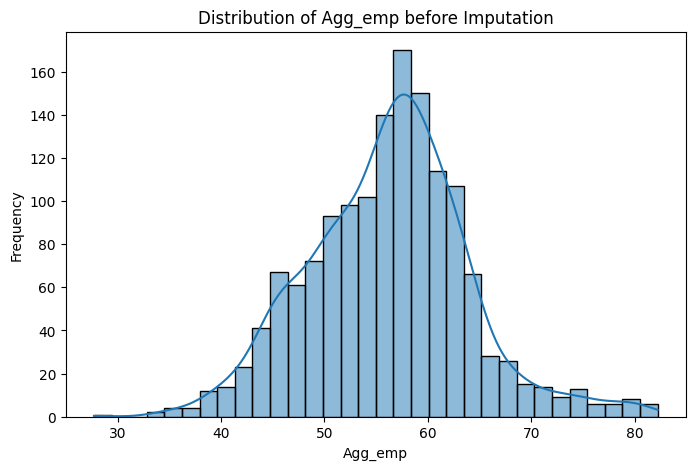

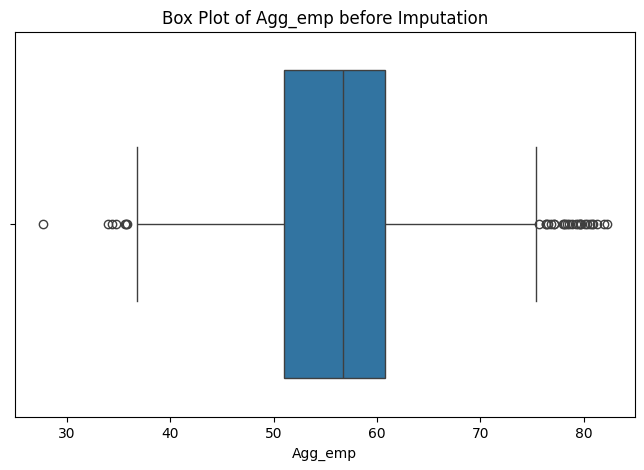


--- Analysis for column: Dmy_MHTX ---
Descriptive statistics before imputation:


,Dmy_MHTX
count,1485.000000
mean,36.177725
std,27.536710
min,0.000000
25%,0.000000
50%,43.479210
75%,59.043916
max,85.388372


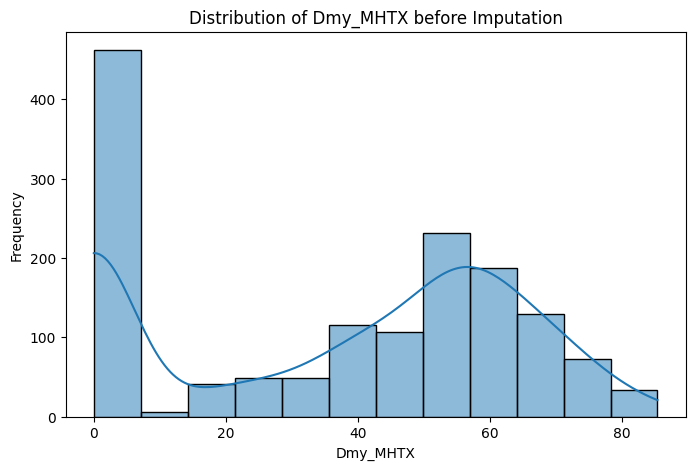

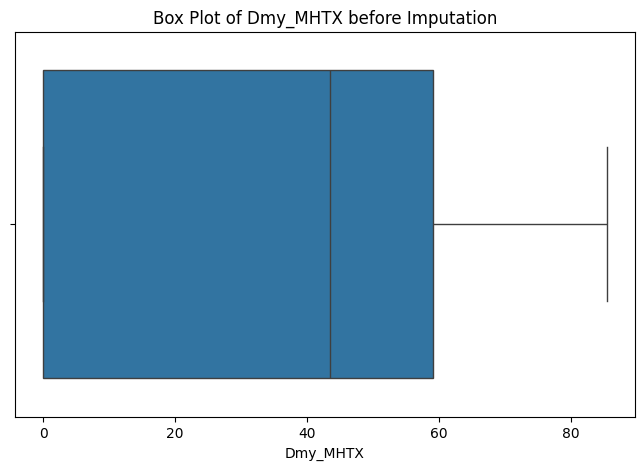


--- Analysis for column: Dmy_UVIndex ---
Descriptive statistics before imputation:


,Dmy_UVIndex
count,1152.000000
mean,65.285677
std,53.266806
min,0.000000
25%,0.000000
50%,87.500000
75%,111.125000
max,236.300000


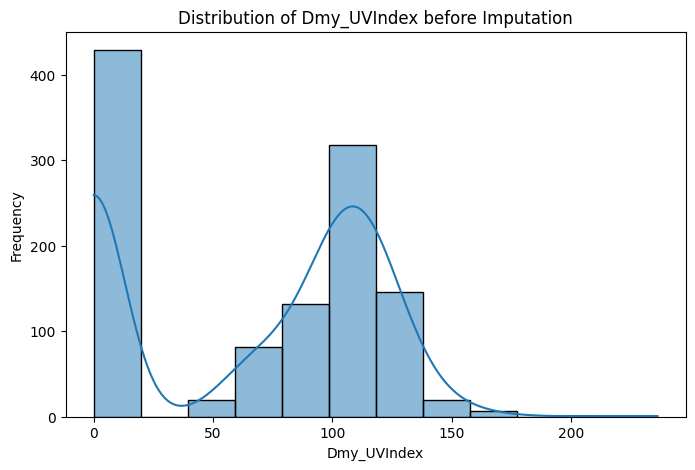

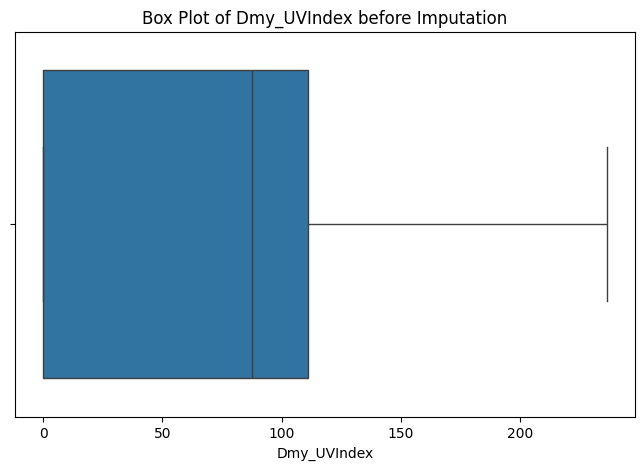


--- Analysis for column: FDI ---
Descriptive statistics before imputation:


,FDI
count,1450.000000
mean,3.523288
std,16.008112
min,-440.130675
25%,0.966990
50%,2.158711
75%,4.081609
max,234.248695


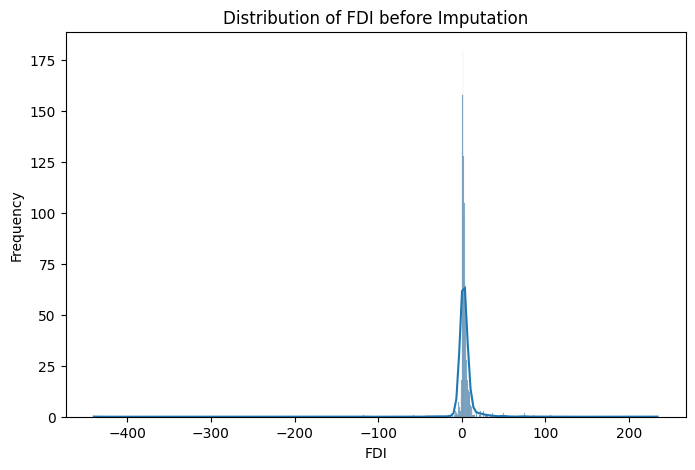

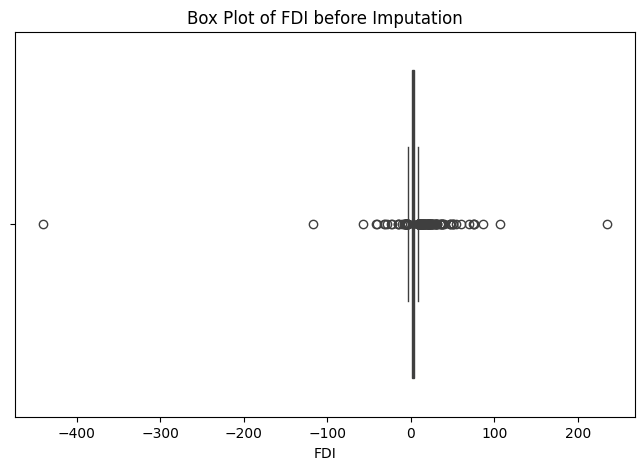


--- Analysis for column: GFCF ---
Descriptive statistics before imputation:


,GFCF
count,1466.000000
mean,24.012701
std,5.462249
min,10.853905
25%,20.641833
50%,23.144961
75%,26.267604
max,53.713554


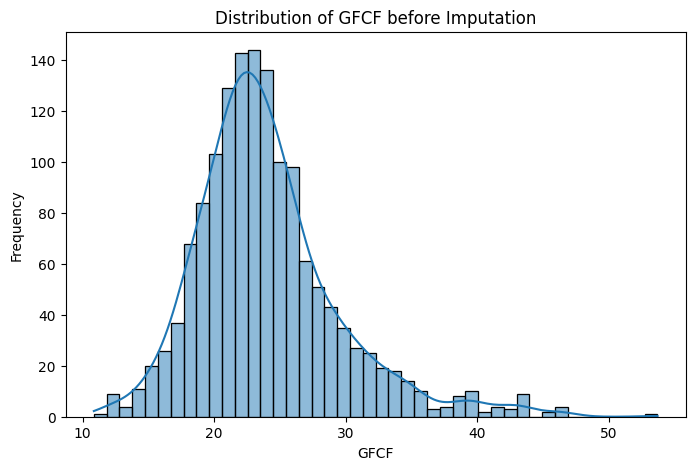

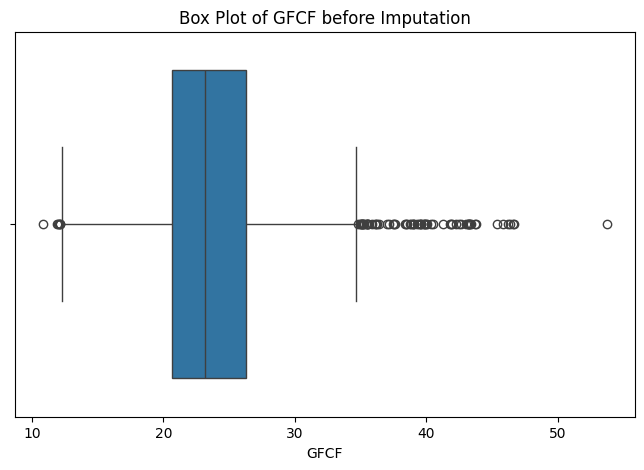


--- Analysis for column: Internet ---
Descriptive statistics before imputation:


,Internet
count,1444.000000
mean,45.787355
std,35.434775
min,0.000000
25%,5.710000
50%,49.050000
75%,80.025000
max,100.000000


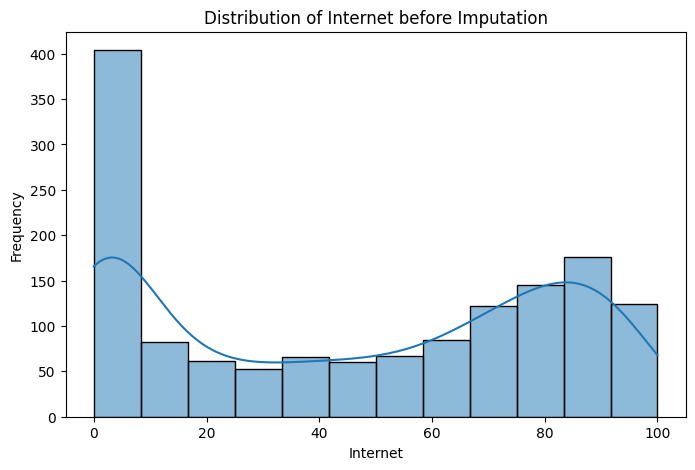

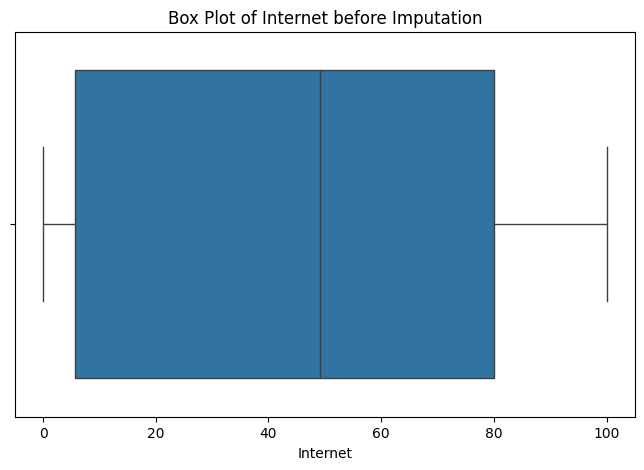


--- Analysis for column: Ln_wages ---
Descriptive statistics before imputation:


,Ln_wages
count,1284.000000
mean,23.525320
std,1.410181
min,19.110285
25%,22.578011
50%,23.584671
75%,24.351192
max,26.955617


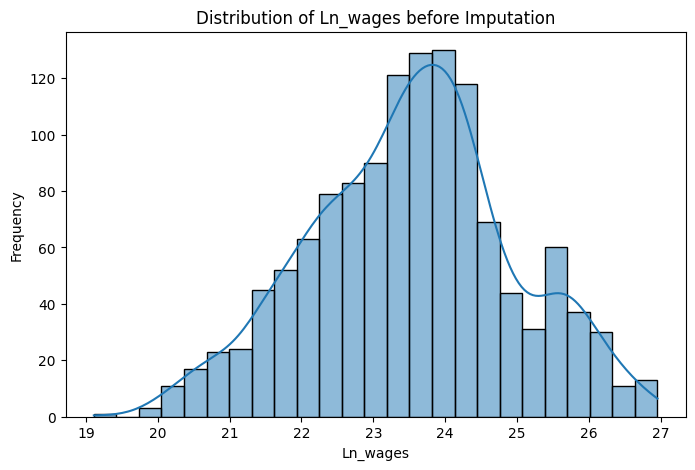

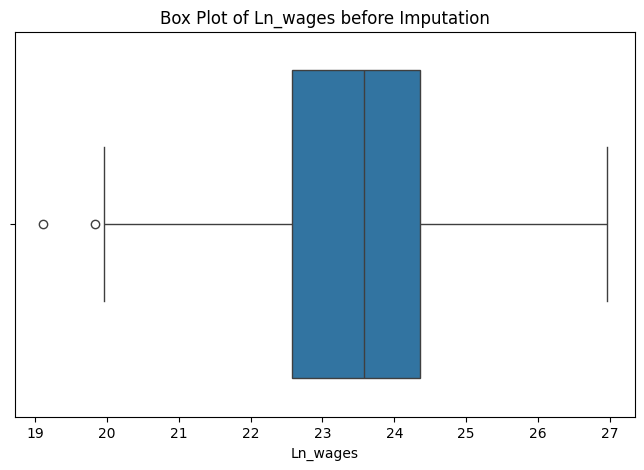


--- Analysis for column: MHTX ---
Descriptive statistics before imputation:


,MHTX
count,1485.000000
mean,48.740722
std,17.323180
min,7.602086
25%,36.675590
50%,50.372419
75%,61.058261
max,85.388372


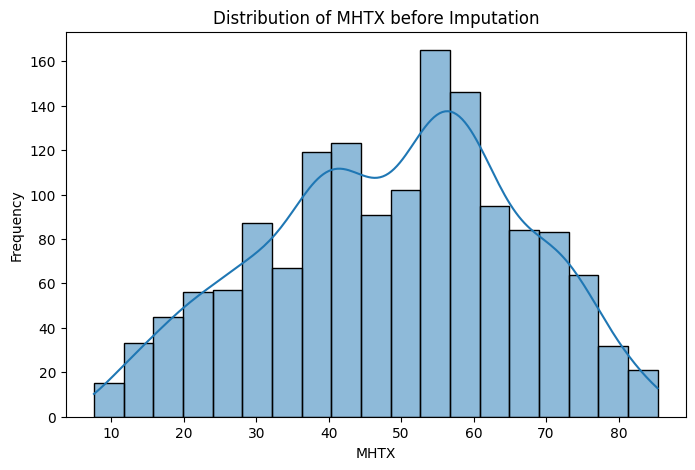

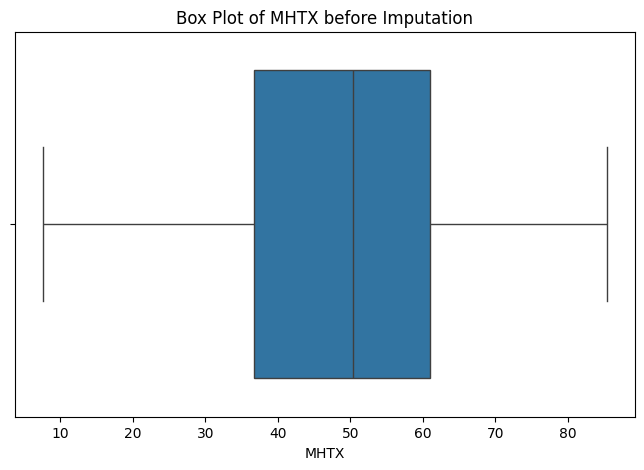


--- Analysis for column: MSCH ---
Descriptive statistics before imputation:


,MSCH
count,1485.000000
mean,10.481223
std,2.433301
min,2.780574
25%,9.001617
50%,11.080000
75%,12.390000
max,14.296372


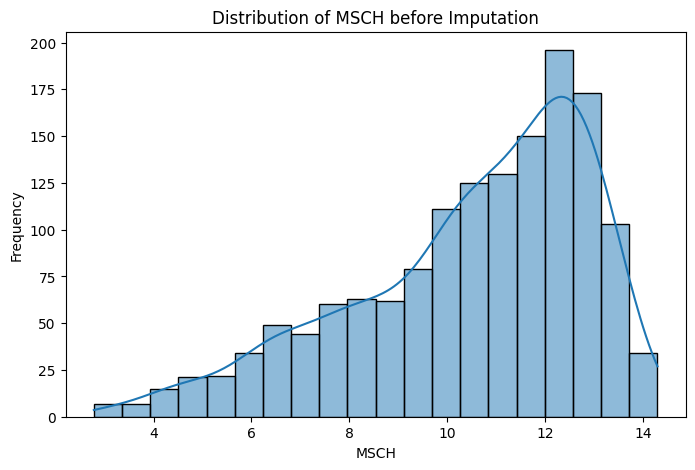

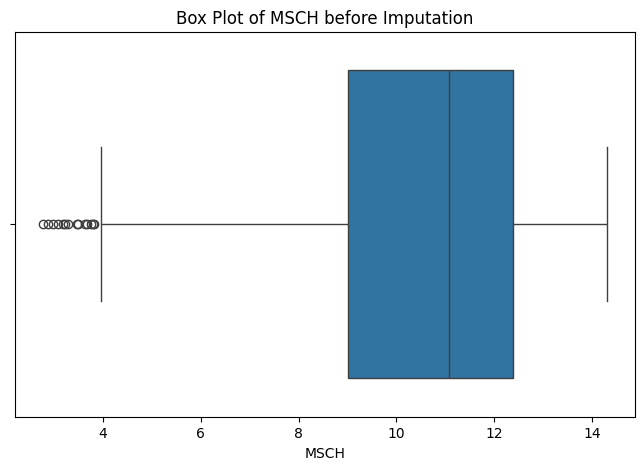


--- Analysis for column: Mobile ---
Descriptive statistics before imputation:


,Mobile
count,1483.000000
mean,73.905589
std,52.613785
min,0.000000
25%,11.678259
50%,89.054328
75%,118.299240
max,179.098864


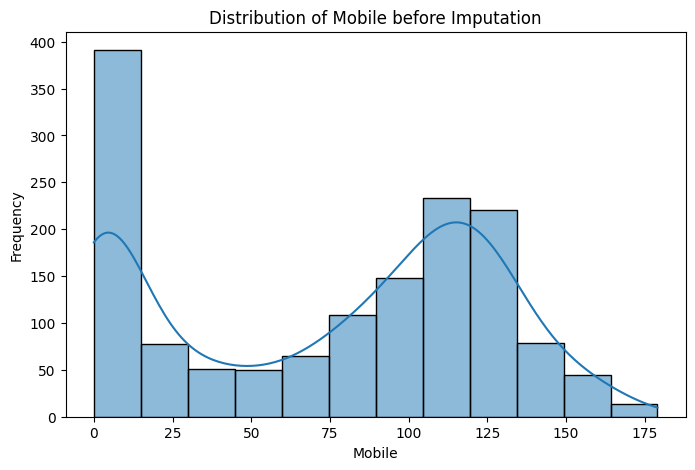

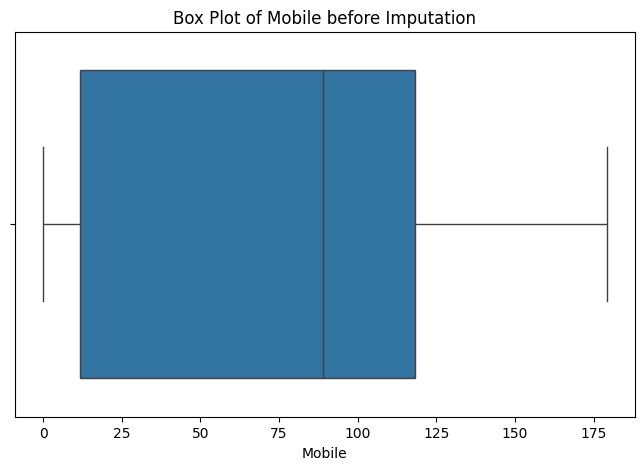


--- Analysis for column: REER ---
Descriptive statistics before imputation:


,REER
count,1461.000000
mean,98.012812
std,19.218900
min,13.712023
25%,90.374332
50%,98.698394
75%,104.777389
max,234.983778


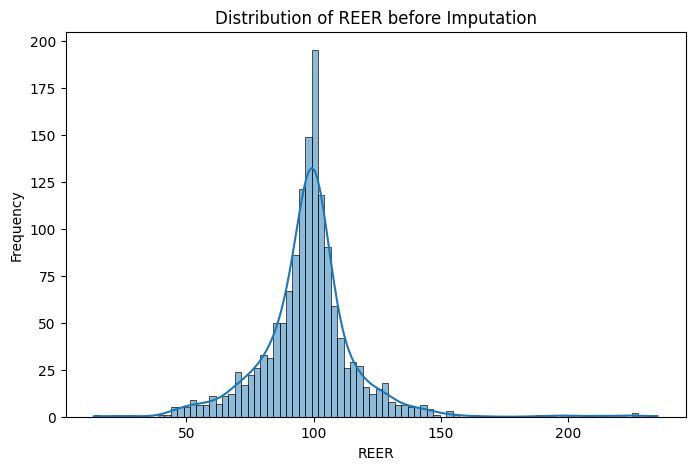

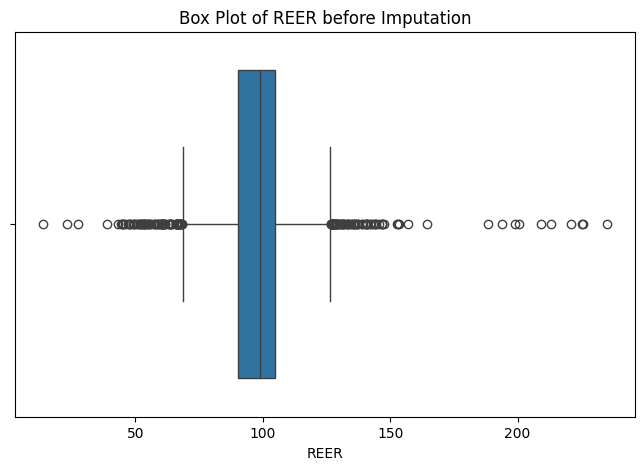


--- Analysis for column: RnD ---
Descriptive statistics before imputation:


,RnD
count,1084.000000
mean,1.626238
std,1.026401
min,0.042300
25%,0.791770
50%,1.405060
75%,2.264115
max,6.019240


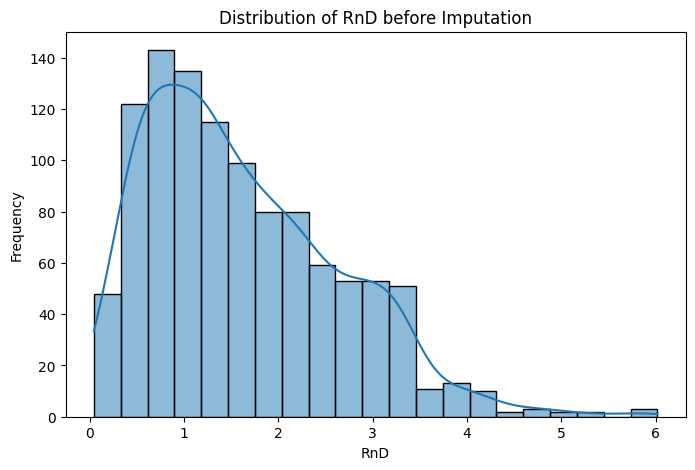

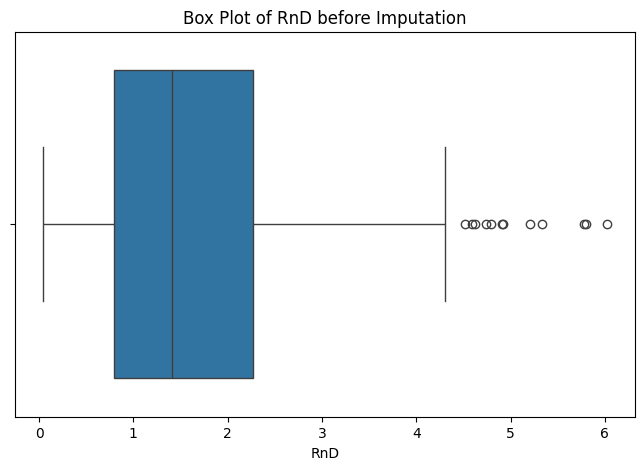


--- Analysis for column: Tariff ---
Descriptive statistics before imputation:


,Tariff
count,1136.000000
mean,4.046224
std,4.247880
min,0.000000
25%,1.830000
50%,2.315000
75%,4.610000
max,56.360000


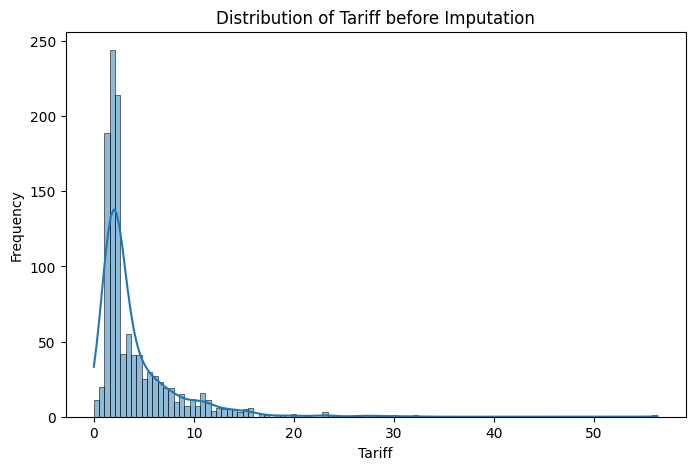

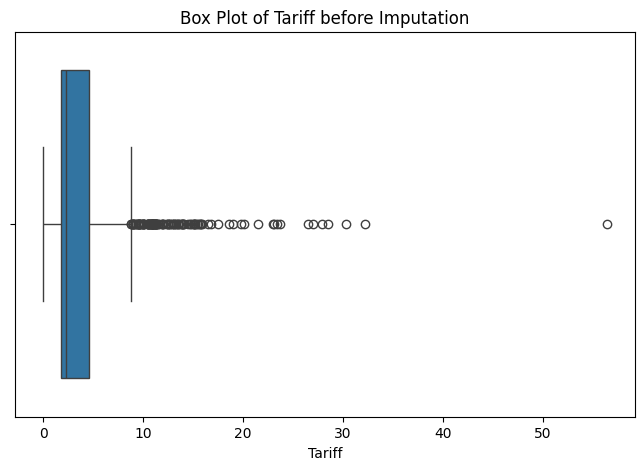


--- Analysis for column: UV_Index ---
Descriptive statistics before imputation:


,UV_Index
count,1152.000000
mean,100.728559
std,27.180746
min,25.600000
25%,82.000000
50%,102.500000
75%,116.500000
max,236.300000


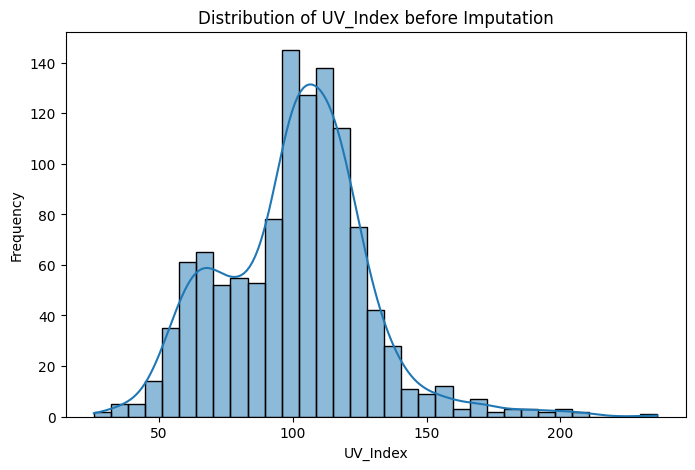

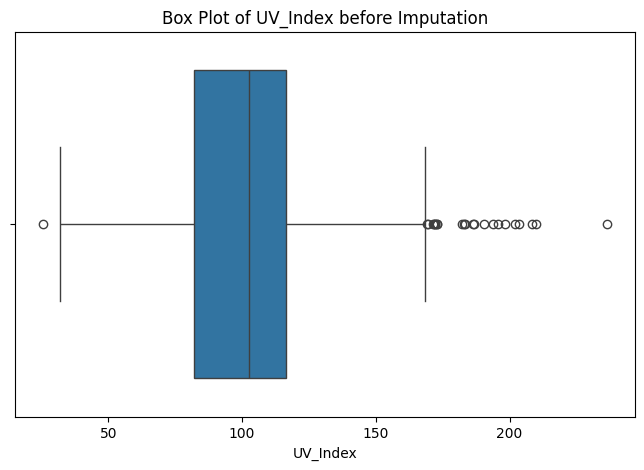


--- Analysis for column: d1 ---
Descriptive statistics before imputation:


,d1
count,1485.000000
mean,0.688889
std,0.463104
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


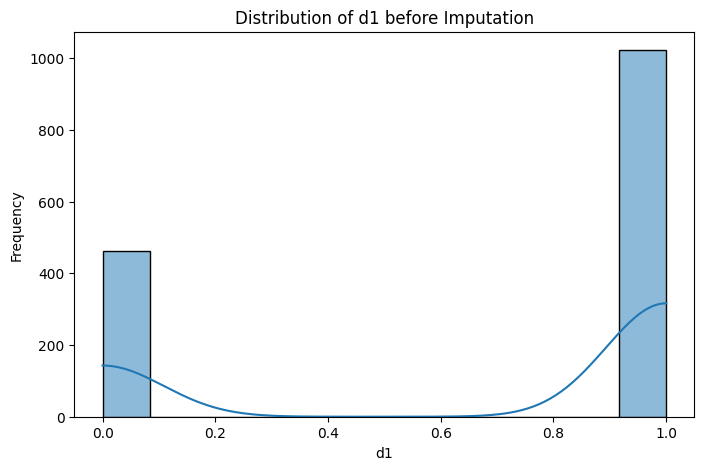

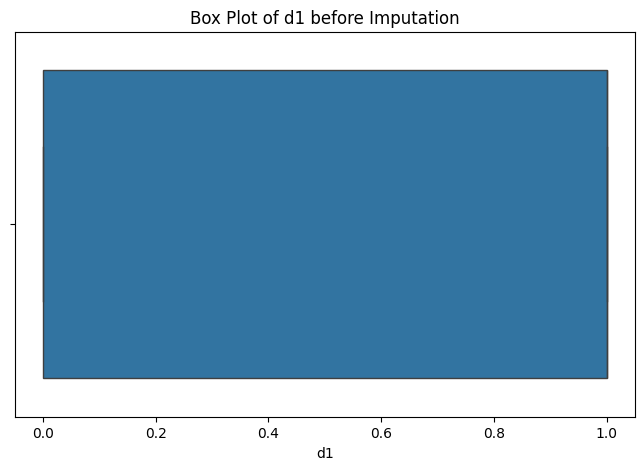

In [ ]:
# Examine the distribution of all numeric columns that were imputed
# Exclude 'Time' and 'ctryid' as they are identifiers
import matplotlib.pyplot as plt
import seaborn as sns

imputed_variables = [col for col in numeric_cols if col not in ['Time', 'ctryid']]

for col in imputed_variables:
    print(f"\n--- Analysis for column: {col} ---")
    print("Descriptive statistics before imputation:")
    display(df_wide[col].describe())

    # Plot histogram
    plt.figure(figsize=(8, 5))
    sns.histplot(df_wide[col].dropna(), kde=True)
    plt.title(f'Distribution of {col} before Imputation')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

    # Plot box plot
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=df_wide[col].dropna())
    plt.title(f'Box Plot of {col} before Imputation')
    plt.xlabel(col)
    plt.show()

In [ ]:
# ================================================
# STEP 2: Apply Transformations (if needed)
# ================================================
# Identify variables that might benefit from transformation based on the plots
# This is an illustrative list; adjust based on your analysis of the distributions
vars_to_transform = ['FDI', 'Internet', 'Mobile', 'REER', 'RnD', 'Tariff', 'UV_Index']

# Apply log(1+x) transformation to selected variables in df_wide
df_wide_transformed = df_wide.copy()
for var in vars_to_transform:
    if var in df_wide_transformed.columns:
        # Add a small constant (1) before log to handle zero values
        df_wide_transformed[f'Ln_{var}'] = np.log1p(df_wide_transformed[var])
        # Optionally, drop the original untransformed column if you only want to impute the transformed version
        # df_wide_transformed = df_wide_transformed.drop(columns=[var])


# ================================================
# STEP 3: Panel-Specific MICE IMPUTATION on Transformed Data
# ================================================
# Select only numeric columns for MICE imputation from the transformed DataFrame
# Exclude identifier columns ('Country', 'Time') and original untransformed columns
numeric_cols_transformed = df_wide_transformed.select_dtypes(include=np.number).columns.tolist()

# Filter out original untransformed columns if they were kept
numeric_cols_imputation = [col for col in numeric_cols_transformed if col not in vars_to_transform]

df_mice_input_transformed = df_wide_transformed[numeric_cols_imputation]


# Initialize MICE with panel structure on transformed data
mice_transformed = MICEData(df_mice_input_transformed,
                            perturbation_method='gaussian',
                            k_pmm=5)  # Predictive Mean Matching

# Perform MICE imputation updates on the transformed data
print("Performing MICE imputation on transformed data (10 cycles)...")
for _ in range(10):
    mice_transformed.update_all()

print("MICE imputation on transformed data complete.")

Performing MICE imputation on transformed data (10 cycles)...
MICE imputation on transformed data complete.


**Explanation:**

*   We created a copy of `df_wide` to avoid modifying the original.
*   We defined a list `vars_to_transform` based on variables that commonly benefit from log transformation. **You should adjust this list based on your analysis of the distribution plots.**
*   We applied the `np.log1p` (log(1+x)) transformation to the selected variables, creating new columns with `Ln_` prefix.
*   We then selected the numeric columns for MICE imputation, ensuring we use the newly created transformed columns and exclude the original untransformed ones (if they were kept).
*   Finally, we re-initialized `MICEData` and performed the imputation updates using the transformed data.

**Next Steps:**

1.  **Access Imputed Transformed Data:** Retrieve the imputed data using `mice_transformed.data`.
2.  **Back-Transform Imputed Values:** Apply the inverse transformation (e.g., `np.expm1` for log(1+x)) to the imputed values of the transformed variables to get them back to their original scale.
3.  **Combine with Identifiers:** Merge the back-transformed imputed data with the 'Country' and 'Time' identifier columns.
4.  **Proceed with Analysis:** Use the complete imputed and back-transformed DataFrame for your `DoubleML` analysis.

In [ ]:
# ================================================
# STEP 4: Access Imputed Data and Back-Transform
# ================================================

# Access the imputed data from the MICE object (this is on the transformed scale for some variables)
imputed_data_transformed_scale = mice_transformed.data

# Identify columns that were log-transformed and need back-transformation
# Exclude 'Ln_wages' as it was already on the log scale
transformed_cols_to_backtransform = [col for col in imputed_data_transformed_scale.columns if col.startswith('Ln_') and col != 'Ln_wages']
original_cols_backtransformed = [col.replace('Ln_', '') for col in transformed_cols_to_backtransform]

# Create a copy to store the back-transformed data and other imputed variables
imputed_data_original_scale = imputed_data_transformed_scale.copy()

# Back-transform the imputed values for the specified transformed columns
for ln_col, original_col in zip(transformed_cols_to_backtransform, original_cols_backtransformed):
    # Apply inverse transformation (expm1 for log1p)
    imputed_data_original_scale[original_col] = np.expm1(imputed_data_original_scale[ln_col])
    # Optionally, drop the transformed column if you only want the back-transformed one
    # imputed_data_original_scale = imputed_data_original_scale.drop(columns=[ln_col])

# Select the final set of numeric columns: back-transformed columns, non-transformed columns, and 'Ln_wages'
final_numeric_cols = original_cols_backtransformed + non_transformed_cols

# Ensure 'Ln_wages' is in the final numeric columns list if it exists in the imputed data
if 'Ln_wages' in imputed_data_transformed_scale.columns and 'Ln_wages' not in final_numeric_cols:
     final_numeric_cols.append('Ln_wages')

# Reorder columns to match the original imputed_data_transformed_scale order as much as possible,
# while placing back-transformed variables with their original names.
# A simple way is to take all columns from imputed_data_original_scale after back-transformation
imputed_data_final_numeric = imputed_data_original_scale[final_numeric_cols]

# ================================================
# STEP 5: Combine with Identifiers
# ================================================

# Combine the final imputed numeric data with the identifier columns from the original wide DataFrame
# Ensure the order of rows matches
imputed_df_final = df_wide[['Country', 'Time']].copy().reset_index(drop=True)


# Add the imputed and back-transformed numeric data
# Ensure columns are added in a consistent order if possible, matching imputed_data_final_numeric
for col in imputed_data_final_numeric.columns:
     imputed_df_final[col] = imputed_data_final_numeric[col].values # Use .values to ensure alignment


# Display the head of the final imputed DataFrame
print("Final Imputed DataFrame Head:")
display(imputed_df_final.head())

# Display info to check data types and non-null counts
print("\nFinal Imputed DataFrame Info:")
imputed_df_final.info()

Final Imputed DataFrame Head:


variable,Country,Time,FDI,Internet,Mobile,REER,RnD,Tariff,UV_Index,Agg_emp,Dmy_MHTX,Dmy_UVIndex,GFCF,MHTX,MSCH,ctryid,d1,Ln_wages
0,Argentina,1990,1.298879,0.00000,0.036767,52.940209,0.80507,30.29,40.5,46.6,0.0,0.0,13.996982,23.624434,8.122559,1.0,0.0,22.484550
1,Argentina,1991,1.285579,0.00000,0.075516,115.974538,1.06198,10.84,50.2,47.0,0.0,0.0,14.636977,23.624434,8.190000,1.0,0.0,22.736755
2,Argentina,1992,1.936795,0.00299,0.138792,188.564866,0.91310,12.66,52.4,47.3,0.0,0.0,16.702406,23.624434,8.258000,1.0,0.0,22.655485
3,Argentina,1993,1.179803,0.02950,0.329148,221.029660,4.01998,12.53,52.9,47.1,0.0,0.0,19.688110,28.972184,8.326000,1.0,0.0,22.771680
4,Argentina,1994,1.411953,0.04370,0.699252,213.286200,2.03279,28.51,57.3,44.8,0.0,0.0,19.965623,30.006418,8.394000,1.0,0.0,22.884668



Final Imputed DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1485 entries, 0 to 1484
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Country      1485 non-null   object 
 1   Time         1485 non-null   int64  
 2   FDI          1485 non-null   float64
 3   Internet     1485 non-null   float64
 4   Mobile       1485 non-null   float64
 5   REER         1485 non-null   float64
 6   RnD          1485 non-null   float64
 7   Tariff       1485 non-null   float64
 8   UV_Index     1485 non-null   float64
 9   Agg_emp      1485 non-null   float64
 10  Dmy_MHTX     1485 non-null   float64
 11  Dmy_UVIndex  1485 non-null   float64
 12  GFCF         1485 non-null   float64
 13  MHTX         1485 non-null   float64
 14  MSCH         1485 non-null   float64
 15  ctryid       1485 non-null   float64
 16  d1           1485 non-null   float64
 17  Ln_wages     1485 non-null   float64
dtypes: float64(16), i

In [ ]:
# Examine descriptive statistics of the final imputed DataFrame
print("Descriptive statistics of the final imputed DataFrame:")
display(imputed_df_final.describe())

Descriptive statistics of the final imputed DataFrame:


variable,Time,FDI,Internet,Mobile,REER,RnD,Tariff,UV_Index,Agg_emp,Dmy_MHTX,Dmy_UVIndex,GFCF,MHTX,MSCH,ctryid,d1,Ln_wages
count,1485.000000,1485.000000,1485.000000,1485.000000,1485.000000,1485.000000,1485.00000,1485.000000,1485.000000,1485.000000,1485.000000,1485.000000,1485.000000,1485.000000,1485.000000,1485.000000,1485.000000
mean,2006.000000,4.455348,44.623470,73.960816,97.963854,1.506328,4.62862,92.245589,56.170671,36.177725,67.867205,24.001421,48.740722,10.481223,23.000000,0.688889,23.496417
std,9.525112,9.927989,35.668307,52.599836,19.212638,1.013896,4.65890,30.167557,7.744796,27.536710,49.533748,5.443424,17.323180,2.433301,12.991548,0.463104,1.418454
min,1990.000000,-0.992569,0.000000,0.000000,13.712023,0.042300,0.00000,25.600000,27.700000,0.000000,0.000000,10.853905,7.602086,2.780574,1.000000,0.000000,19.110285
25%,1998.000000,1.178522,4.370000,11.819277,90.288572,0.698950,1.85000,65.400000,51.004000,0.000000,0.000000,20.644640,36.675590,9.001617,12.000000,0.000000,22.565042
50%,2006.000000,2.296313,46.800000,89.147666,98.687689,1.238980,2.56000,95.300000,56.677000,43.479210,85.300000,23.145172,50.372419,11.080000,23.000000,1.000000,23.573794
75%,2014.000000,4.313939,79.500000,118.251709,104.880581,2.138800,5.77000,112.400000,60.783000,59.043916,108.300000,26.250464,61.058261,12.390000,34.000000,1.000000,24.340902
max,2022.000000,234.248695,100.000000,179.098864,234.983778,6.019240,56.36000,236.300000,82.223000,85.388372,236.300000,53.713554,85.388372,14.296372,45.000000,1.000000,26.955617


In [ ]:
# ================================================
# STEP 2 (Revised): Apply Winsorizing and Transformations
# ================================================

# Create a copy of df_wide for winsorizing and transformation
df_processed = df_wide.copy()

# Identify numeric columns for winsorizing (exclude identifiers)
numeric_cols_for_winsorizing = [col for col in df_processed.select_dtypes(include=np.number).columns.tolist() if col not in ['Time', 'ctryid']]

print("Applying winsorizing to variables:", numeric_cols_for_winsorizing)

# Apply winsorizing at 1st and 99th percentiles to the numeric columns
for col in numeric_cols_for_winsorizing:
    if col in df_processed.columns:
        # Calculate percentiles based on non-missing values
        lower_bound = df_processed[col].quantile(0.01) # Changed from 0.05 to 0.01
        upper_bound = df_processed[col].quantile(0.99) # Changed from 0.95 to 0.99

        # Apply winsorizing
        df_processed[col] = df_processed[col].clip(lower=lower_bound, upper=upper_bound)

print("Winsorizing complete.")

# Apply log(1+x) transformation to selected variables in the winsorized data
# Use the same list of variables as before; adjust based on your analysis
vars_to_transform = ['FDI', 'Internet', 'Mobile', 'REER', 'RnD', 'Tariff', 'UV_Index']

df_winsorized_transformed = df_processed.copy()
for var in vars_to_transform:
    if var in df_winsorized_transformed.columns:
        # Add a small constant (1) before log to handle zero values, applies to winsorized values
        df_winsorized_transformed[f'Ln_{var}'] = np.log1p(df_winsorized_transformed[var])
        # Optionally, drop the original untransformed column if you only want to impute the transformed version
        # df_winsorized_transformed = df_winsorized_transformed.drop(columns=[var])


# ================================================
# STEP 3 (Revised): Panel-Specific MICE IMPUTATION on Winsorized and Transformed Data
# ================================================
# Select only numeric columns for MICE imputation from the winsorized and transformed DataFrame
# Exclude identifier columns ('Country', 'Time') and original untransformed columns
numeric_cols_winsorized_transformed = df_winsorized_transformed.select_dtypes(include=np.number).columns.tolist()

# Filter out original untransformed columns if they were kept
numeric_cols_imputation_winsorized_transformed = [col for col in numeric_cols_winsorized_transformed if col not in vars_to_transform]

df_mice_input_winsorized_transformed = df_winsorized_transformed[numeric_cols_imputation_winsorized_transformed]


# Initialize MICE with panel structure on winsorized and transformed data
# Using k_pmm=10 as agreed, but you can experiment further
mice_winsorized_transformed = MICEData(df_mice_input_winsorized_transformed,
                                      perturbation_method='gaussian',
                                      k_pmm=10)

# Perform MICE imputation updates
print("Performing MICE imputation on winsorized and transformed data (10 cycles)...")
for _ in range(10):
    mice_winsorized_transformed.update_all()

print("MICE imputation on winsorized and transformed data complete.")


# ================================================
# STEP 4 & 5 (Revised): Access Imputed Data, Back-Transform, and Combine
# ================================================

# Access the imputed data from the MICE object
imputed_data_wt_scale = mice_winsorized_transformed.data

# Identify columns that were log-transformed and need back-transformation (excluding Ln_wages)
transformed_cols_to_backtransform_wt = [col for col in imputed_data_wt_scale.columns if col.startswith('Ln_') and col != 'Ln_wages']
original_cols_backtransformed_wt = [col.replace('Ln_', '') for col in transformed_cols_to_backtransform_wt]

# Create a copy to store the back-transformed data and other imputed variables
imputed_data_original_scale_wt = imputed_data_wt_scale.copy()

# Back-transform the imputed values for the specified transformed columns
for ln_col, original_col in zip(transformed_cols_to_backtransform_wt, original_cols_backtransformed_wt):
    # Apply inverse transformation (expm1 for log1p)
    imputed_data_original_scale_wt[original_col] = np.expm1(imputed_data_original_scale_wt[ln_col])
    # Optionally, drop the transformed column if you only want the back-transformed one
    # imputed_data_original_scale_wt = imputed_data_original_scale_wt.drop(columns=[ln_col])


# Select the final set of numeric columns: back-transformed columns, non-transformed columns, and 'Ln_wages'
# Need to be careful here to select the right columns from imputed_data_original_scale_wt and imputed_data_wt_scale
final_numeric_cols_wt = original_cols_backtransformed_wt # These are the back-transformed columns

# Add non-transformed numeric columns from the imputed data (including Ln_wages and those not in vars_to_transform)
non_transformed_imputed_cols = [col for col in imputed_data_wt_scale.columns if col not in transformed_cols_to_backtransform_wt] # Exclude those that were back-transformed
final_numeric_cols_wt.extend(non_transformed_imputed_cols)


# Combine the final imputed numeric data with the identifier columns from the original wide DataFrame
imputed_df_final_winsorized = df_wide[['Country', 'Time']].copy().reset_index(drop=True)

# Add the imputed and back-transformed numeric data
for col in final_numeric_cols_wt:
     if col in imputed_data_original_scale_wt.columns:
          imputed_df_final_winsorized[col] = imputed_data_original_scale_wt[col].values
     elif col in imputed_data_wt_scale.columns:
          imputed_df_final_winsorized[col] = imputed_data_wt_scale[col].values


# Display the head of the final imputed DataFrame after winsorizing and transformation
print("\nFinal Imputed DataFrame Head (after winsorizing and transformation):")
display(imputed_df_final_winsorized.head())

# Display info to check data types and non-null counts
print("\nFinal Imputed DataFrame Info (after winsorizing and transformation):")
imputed_df_final_winsorized.info()

# Examine descriptive statistics of the final imputed DataFrame after winsorizing
print("\nDescriptive statistics of the final imputed DataFrame (after winsorizing and transformation):")
display(imputed_df_final_winsorized.describe())

Applying winsorizing to variables: ['Agg_emp', 'Dmy_MHTX', 'Dmy_UVIndex', 'FDI', 'GFCF', 'Internet', 'Ln_wages', 'MHTX', 'MSCH', 'Mobile', 'REER', 'RnD', 'Tariff', 'UV_Index', 'd1']
Winsorizing complete.
Performing MICE imputation on winsorized and transformed data (10 cycles)...
MICE imputation on winsorized and transformed data complete.

Final Imputed DataFrame Head (after winsorizing and transformation):


variable,Country,Time,FDI,Internet,Mobile,REER,RnD,Tariff,UV_Index,Agg_emp,Dmy_MHTX,Dmy_UVIndex,GFCF,Ln_wages,MHTX,MSCH,ctryid,d1
0,Argentina,1990,1.298879,0.00000,0.036767,88.315556,0.72567,11.91,44.979,46.6,0.0,0.0,13.996982,22.484550,23.624434,8.122559,1.0,0.0
1,Argentina,1991,1.285579,0.02610,0.075516,84.360203,0.76541,8.53,50.200,47.0,0.0,0.0,14.636977,22.736755,23.624434,8.190000,1.0,0.0
2,Argentina,1992,1.936795,0.00299,0.138792,149.676993,1.27156,12.66,52.400,47.3,0.0,0.0,16.702406,22.655485,23.624434,8.258000,1.0,0.0
3,Argentina,1993,1.179803,0.02950,0.329148,149.676993,0.79204,12.53,52.900,47.1,0.0,0.0,19.688110,22.771680,28.972184,8.326000,1.0,0.0
4,Argentina,1994,1.411953,0.04370,0.699252,149.676993,0.88400,13.08,57.300,44.8,0.0,0.0,19.965623,22.884668,30.006418,8.394000,1.0,0.0



Final Imputed DataFrame Info (after winsorizing and transformation):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1485 entries, 0 to 1484
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Country      1485 non-null   object 
 1   Time         1485 non-null   int64  
 2   FDI          1485 non-null   float64
 3   Internet     1485 non-null   float64
 4   Mobile       1485 non-null   float64
 5   REER         1485 non-null   float64
 6   RnD          1485 non-null   float64
 7   Tariff       1485 non-null   float64
 8   UV_Index     1485 non-null   float64
 9   Agg_emp      1485 non-null   float64
 10  Dmy_MHTX     1485 non-null   float64
 11  Dmy_UVIndex  1485 non-null   float64
 12  GFCF         1485 non-null   float64
 13  Ln_wages     1485 non-null   float64
 14  MHTX         1485 non-null   float64
 15  MSCH         1485 non-null   float64
 16  ctryid       1485 non-null   float64
 17  d1           1485 no

variable,Time,FDI,Internet,Mobile,REER,RnD,Tariff,UV_Index,Agg_emp,Dmy_MHTX,Dmy_UVIndex,GFCF,Ln_wages,MHTX,MSCH,ctryid,d1
count,1485.000000,1485.000000,1485.000000,1485.000000,1485.000000,1485.000000,1485.000000,1485.000000,1485.000000,1485.000000,1485.000000,1485.000000,1485.000000,1485.000000,1485.000000,1485.000000,1485.000000
mean,2006.000000,4.066196,44.625084,73.890507,97.623556,1.468326,4.462698,92.599120,56.225698,36.160218,68.758608,24.010666,23.513169,48.739451,10.485255,23.000000,0.688889
std,9.525112,6.412515,35.649049,52.495677,16.900050,0.978334,4.016206,28.750627,7.635806,27.506631,49.364573,5.334058,1.420665,17.251957,2.414387,12.991548,0.463104
min,1990.000000,-0.992569,0.000000,0.000000,49.107433,0.123179,0.633500,44.979000,38.784220,0.000000,0.000000,13.966234,20.325933,11.726793,3.976402,1.000000,0.000000
25%,1998.000000,1.153145,4.360000,11.819277,90.220386,0.686160,1.850000,67.300000,51.026000,0.000000,0.000000,20.673641,22.558456,36.675590,9.001617,12.000000,0.000000
50%,2006.000000,2.257819,46.800000,89.147666,98.683831,1.217000,2.520000,95.400000,56.683000,43.479210,88.500000,23.145172,23.576538,50.372419,11.080000,23.000000,1.000000
75%,2014.000000,4.207168,79.500000,118.251709,104.754905,2.107670,5.830000,112.400000,60.834000,59.043916,108.500000,26.250464,24.353964,61.058261,12.390000,34.000000,1.000000
max,2022.000000,42.905092,98.200000,163.690752,149.676993,4.528551,20.988000,183.045000,78.446840,82.474373,150.741000,43.057748,26.637082,82.474373,13.909098,45.000000,1.000000


In [ ]:
outcome = 'Agg_emp'
treatment = 'MHTX'
controls = ['GFCF', 'RnD', 'Internet', 'Mobile', 'FDI', 'Ln_wages', 'Tariff', 'MSCH', 'REER'] # Corrected Ln_Wages to Ln_wages
time_var = 'Time'
entity_var = 'ctryid'

dml_data = DoubleMLPanelData(
    data=imputed_df_final_winsorized, # Changed input data to the latest imputed dataframe
    y_col=outcome,
    d_cols=[treatment],
    x_cols=controls,
    t_col=time_var,
    id_col=entity_var,
    trimming_rule='truncate', # Moved trimming to DoubleMLPanelData
    trimming_threshold=1e-2 # Moved trimming to DoubleMLPanelData
)

TypeError: DoubleMLPanelData.__init__() got an unexpected keyword argument 'trimming_rule'

In [ ]:
ml_l = RandomForestRegressor(n_estimators=200, min_samples_leaf=5, random_state=42)
ml_m = LassoCV(cv=5, max_iter=10000)


In [ ]:
ml_l = RandomForestRegressor(n_estimators=200, min_samples_leaf=5, random_state=42)
ml_m = LassoCV(cv=5, max_iter=10000)

dml_plr = DoubleMLPLR(
    dml_data,
    ml_l=ml_l,
    ml_m=ml_m,
    n_folds=3, # Keeping n_folds as 3 for now as in the original cell
    n_rep=1,  # Changed n_rep to 1
    # Removed score='partialling out' as it's the default
)
dml_plr.fit()

AssertionError: 

In [ ]:
# Initialize DoubleMLPLR model
dml_plr = DoubleMLPLR(
    dml_data,
    ml_l=ml_l,
    ml_m=ml_m,
    n_folds=5 # You can adjust the number of folds for cross-fitting
)

# Fit the model
dml_plr.fit(
    trimming_rule='truncate', # Moved from constructor to fit()
    trimming_threshold=1e-2 # Moved from constructor to fit()
)

# Display the results
print(dml_plr)

TypeError: DoubleML.fit() got an unexpected keyword argument 'trimming_rule'

In [ ]:
from sklearn.model_selection import GroupKFold
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LassoCV

# ================================================
# STEP 1: Prepare Data and Initialize
# ================================================

outcome = 'Agg_emp'
treatment = 'MHTX' # Treatment is MHTX
# Updated controls: removed UV_Index, kept MHTX in original list and removed UV_Index
controls = ['GFCF', 'RnD', 'Internet', 'Mobile', 'FDI', 'Ln_wages', 'Tariff', 'MSCH', 'REER'] # Removed UV_Index


time_var = 'Time'
entity_var = 'ctryid'


# Extract outcome (Y), treatment (D), covariates (X), and groups (entity IDs)
Y = imputed_df_final_winsorized[outcome]
D = imputed_df_final_winsorized[treatment]
X = imputed_df_final_winsorized[controls].copy() # Create a copy to avoid modifying original df_final_winsorized
groups = imputed_df_final_winsorized[entity_var]

# Add squared terms for continuous covariates to capture potential non-linearity
# Ensure the list of continuous controls reflects the updated controls list
continuous_controls = ['GFCF', 'RnD', 'Internet', 'Mobile', 'FDI', 'Ln_wages', 'Tariff', 'MSCH', 'REER'] # Updated list
for col in continuous_controls:
    if col in X.columns:
        X[f'{col}_squared'] = X[col]**2

# Initialize models for outcome and treatment nuisance regressions
# Changing ml_y to GradientBoostingRegressor and adjusting parameters for RandomForestRegressor (ml_d)
ml_y = GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, max_depth=4, random_state=42) # Example parameters
ml_d = RandomForestRegressor(n_estimators=200, min_samples_leaf=5, random_state=42) # Adjusted parameters


# Initialize GroupKFold for panel data cross-validation
n_folds = 5 # You can adjust the number of folds
gkf = GroupKFold(n_splits=n_folds)

# Initialize arrays to store residuals for PLR
resid_y_plr = np.zeros_like(Y)
resid_d_plr = np.zeros_like(D)

# Convert X to numpy array for scikit-learn models if it's not already
X_np = X.values

# ================================================
# STEP 2: Cross-Validation and Residual Calculation (PLR)
# ================================================

print(f"Performing {n_folds}-fold cross-validation...")

for train_idx, test_idx in gkf.split(X_np, Y, groups=groups):
    X_train, X_test = X_np[train_idx], X_np[test_idx]
    D_train, D_test = D.iloc[train_idx], D.iloc[test_idx]
    Y_train, Y_test = Y.iloc[train_idx], Y.iloc[test_idx]

    # Fit outcome model on controls only
    ml_y.fit(X_train, Y_train)
    Y_pred = ml_y.predict(X_test)
    resid_y_plr[test_idx] = Y_test - Y_pred

    # Fit treatment model on controls
    ml_d.fit(X_train, D_train)
    D_pred = ml_d.predict(X_test)
    resid_d_plr[test_idx] = D_test - D_pred

print("Residual calculation complete.")

# ================================================
# STEP 3: Estimate Causal Effect
# ================================================

# Regress outcome residuals on treatment residuals (without intercept)
# Add a constant to the treatment residuals for statsmodels regression (though typically not needed for no-intercept)
# Using OLS from statsmodels
model = sm.OLS(resid_y_plr, resid_d_plr) # No constant/intercept
results = model.fit()

# The estimated causal effect is the coefficient of resid_d_plr
causal_effect_estimate = results.params[0]

print("\nManual DoubleML-PLR Estimation Results:")
print(f"Estimated Causal Effect ({treatment} on {outcome}): {causal_effect_estimate}")
print("\nRegression Results Summary:")
print(results.summary())

Performing 5-fold cross-validation...
Residual calculation complete.

Manual DoubleML-PLR Estimation Results:
Estimated Causal Effect (UV_Index on Agg_emp): -0.002098751018531554

Regression Results Summary:
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.000
Model:                            OLS   Adj. R-squared (uncentered):             -0.001
Method:                 Least Squares   F-statistic:                            0.04893
Date:                Tue, 24 Jun 2025   Prob (F-statistic):                       0.825
Time:                        14:07:08   Log-Likelihood:                         -5000.2
No. Observations:                1485   AIC:                                  1.000e+04
Df Residuals:                    1484   BIC:                                  1.001e+04
Df Model:                           1                                                  


In [1]:
# ================================================
# STEP 1: Prepare Data and Initialize (MHTX as treatment, UV_Index removed from controls)
# ================================================

outcome = 'Agg_emp'
treatment = 'MHTX' # Treatment is MHTX
# Updated controls: removed UV_Index, kept MHTX in original list and removed UV_Index
controls = ['GFCF', 'RnD', 'Internet', 'Mobile', 'FDI', 'Ln_wages', 'Tariff', 'MSCH', 'REER'] # Removed UV_Index


time_var = 'Time'
entity_var = 'ctryid'


# Extract outcome (Y), treatment (D), covariates (X), and groups (entity IDs)
Y = imputed_df_final_winsorized[outcome]
D = imputed_df_final_winsorized[treatment]
X = imputed_df_final_winsorized[controls].copy() # Create a copy to avoid modifying original df_final_winsorized
groups = imputed_df_final_winsorized[entity_var]

# Add squared terms for continuous covariates to capture potential non-linearity
# Ensure the list of continuous controls reflects the updated controls list
continuous_controls = ['GFCF', 'RnD', 'Internet', 'Mobile', 'FDI', 'Ln_wages', 'Tariff', 'MSCH', 'REER'] # Updated list
for col in continuous_controls:
    if col in X.columns:
        X[f'{col}_squared'] = X[col]**2

# Initialize models for outcome and treatment nuisance regressions
# Changing ml_y to GradientBoostingRegressor and adjusting parameters for RandomForestRegressor (ml_d)
ml_y = GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, max_depth=4, random_state=42) # Example parameters
ml_d = RandomForestRegressor(n_estimators=200, min_samples_leaf=5, random_state=42) # Adjusted parameters


# Initialize GroupKFold for panel data cross-validation
n_folds = 5 # You can adjust the number of folds
gkf = GroupKFold(n_splits=n_folds)

# Initialize arrays to store residuals for PLR
resid_y_plr = np.zeros_like(Y)
resid_d_plr = np.zeros_like(D)

# Convert X to numpy array for scikit-learn models if it's not already
X_np = X.values

# ================================================
# STEP 2: Cross-Validation and Residual Calculation (PLR)
# ================================================

print(f"Performing {n_folds}-fold cross-validation...")

for train_idx, test_idx in gkf.split(X_np, Y, groups=groups):
    X_train, X_test = X_np[train_idx], X_np[test_idx]
    D_train, D_test = D.iloc[train_idx], D.iloc[test_idx]
    Y_train, Y_test = Y.iloc[train_idx], Y.iloc[test_idx]

    # Fit outcome model on controls only
    ml_y.fit(X_train, Y_train)
    Y_pred = ml_y.predict(X_test)
    resid_y_plr[test_idx] = Y_test - Y_pred

    # Fit treatment model on controls
    ml_d.fit(X_train, D_train)
    D_pred = ml_d.predict(X_test)
    resid_d_plr[test_idx] = D_test - D_pred

print("Residual calculation complete.")

# ================================================
# STEP 3: Estimate Causal Effect
# ================================================

# Regress outcome residuals on treatment residuals (without intercept)
# Add a constant to the treatment residuals for statsmodels regression (though typically not needed for no-intercept)
# Using OLS from statsmodels
model = sm.OLS(resid_y_plr, resid_d_plr) # No constant/intercept
results = model.fit()

# The estimated causal effect is the coefficient of resid_d_plr
causal_effect_estimate = results.params[0]

print("\nManual DoubleML-PLR Estimation Results:")
print(f"Estimated Causal Effect ({treatment} on {outcome}): {causal_effect_estimate}")
print("\nRegression Results Summary:")
print(results.summary())

NameError: name 'imputed_df_final_winsorized' is not defined

In [2]:
# Load your Excel data (replace 'your_data.xlsx' with actual path)
df = pd.read_excel('/content/GColab Data 24.06.2025.xlsx')

NameError: name 'pd' is not defined

In [3]:
# Convert to long format for panel imputation
df_long = df.melt(id_vars=['Country', 'Time'],
                                var_name='variable',
                                value_name='value')

# Replace '..' with NaN before pivoting
df_long['value'] = df_long['value'].replace('..', np.nan)

df_wide = df_long.pivot_table(index=['Country', 'Time'], columns='variable', values='value').reset_index()

# Rename columns with special characters to avoid issues with patsy
if 'Ln(wages)' in df_wide.columns:
    df_wide = df_wide.rename(columns={'Ln(wages)': 'Ln_wages'})
if 'Agg.emp' in df_wide.columns:
    df_wide = df_wide.rename(columns={'Agg.emp': 'Agg_emp'})


# Convert all columns except 'Country', 'Time', and the renamed columns to numeric, coercing errors
# Update the list of columns to exclude from numeric conversion
cols_to_exclude = ['Country', 'Time']
if 'Ln_wages' in df_wide.columns:
    cols_to_exclude.append('Ln_wages')
if 'Agg_emp' in df_wide.columns:
    cols_to_exclude.append('Agg_emp')


for col in df_wide.columns:
    if col not in cols_to_exclude:
        df_wide[col] = pd.to_numeric(df_wide[col], errors='coerce')

NameError: name 'df' is not defined

In [4]:
# ================================================
# STEP 2 (Revised): Apply Winsorizing and Transformations
# ================================================

# Create a copy of df_wide for winsorizing and transformation
df_processed = df_wide.copy()

# Identify numeric columns for winsorizing (exclude identifiers)
numeric_cols_for_winsorizing = [col for col in df_processed.select_dtypes(include=np.number).columns.tolist() if col not in ['Time', 'ctryid']]

print("Applying winsorizing to variables:", numeric_cols_for_winsorizing)

# Apply winsorizing at 1st and 99th percentiles to the numeric columns
for col in numeric_cols_for_winsorizing:
    if col in df_processed.columns:
        # Calculate percentiles based on non-missing values
        lower_bound = df_processed[col].quantile(0.01) # Changed from 0.05 to 0.01
        upper_bound = df_processed[col].quantile(0.99) # Changed from 0.95 to 0.99

        # Apply winsorizing
        df_processed[col] = df_processed[col].clip(lower=lower_bound, upper=upper_bound)

print("Winsorizing complete.")

# Apply log(1+x) transformation to selected variables in the winsorized data
# Use the same list of variables as before; adjust based on your analysis
vars_to_transform = ['FDI', 'Internet', 'Mobile', 'REER', 'RnD', 'Tariff', 'UV_Index']

df_winsorized_transformed = df_processed.copy()
for var in vars_to_transform:
    if var in df_winsorized_transformed.columns:
        # Add a small constant (1) before log to handle zero values, applies to winsorized values
        df_winsorized_transformed[f'Ln_{var}'] = np.log1p(df_winsorized_transformed[var])
        # Optionally, drop the original untransformed column if you only want to impute the transformed version
        # df_winsorized_transformed = df_winsorized_transformed.drop(columns=[var])


# ================================================
# STEP 3 (Revised): Panel-Specific MICE IMPUTATION on Winsorized and Transformed Data
# ================================================
# Select only numeric columns for MICE imputation from the winsorized and transformed DataFrame
# Exclude identifier columns ('Country', 'Time') and original untransformed columns
numeric_cols_winsorized_transformed = df_winsorized_transformed.select_dtypes(include=np.number).columns.tolist()

# Filter out original untransformed columns if they were kept
numeric_cols_imputation_winsorized_transformed = [col for col in numeric_cols_winsorized_transformed if col not in vars_to_transform]

df_mice_input_winsorized_transformed = df_winsorized_transformed[numeric_cols_imputation_winsorized_transformed]


# Initialize MICE with panel structure on winsorized and transformed data
# Using k_pmm=10 as agreed, but you can experiment further
mice_winsorized_transformed = MICEData(df_mice_input_winsorized_transformed,
                                      perturbation_method='gaussian',
                                      k_pmm=10)

# Perform MICE imputation updates
print("Performing MICE imputation on winsorized and transformed data (10 cycles)...")
for _ in range(10):
    mice_winsorized_transformed.update_all()

print("MICE imputation on winsorized and transformed data complete.")


# ================================================
# STEP 4 & 5 (Revised): Access Imputed Data, Back-Transform, and Combine
# ================================================

# Access the imputed data from the MICE object
imputed_data_wt_scale = mice_winsorized_transformed.data

# Identify columns that were log-transformed and need back-transformation (excluding Ln_wages)
transformed_cols_to_backtransform_wt = [col for col in imputed_data_wt_scale.columns if col.startswith('Ln_') and col != 'Ln_wages']
original_cols_backtransformed_wt = [col.replace('Ln_', '') for col in transformed_cols_to_backtransform_wt]

# Create a copy to store the back-transformed data and other imputed variables
imputed_data_original_scale_wt = imputed_data_wt_scale.copy()

# Back-transform the imputed values for the specified transformed columns
for ln_col, original_col in zip(transformed_cols_to_backtransform_wt, original_cols_backtransformed_wt):
    # Apply inverse transformation (expm1 for log1p)
    imputed_data_original_scale_wt[original_col] = np.expm1(imputed_data_original_scale_wt[ln_col])
    # Optionally, drop the transformed column if you only want the back-transformed one
    # imputed_data_original_scale_wt = imputed_data_original_scale_wt.drop(columns=[ln_col])


# Select the final set of numeric columns: back-transformed columns, non-transformed columns, and 'Ln_wages'
# Need to be careful here to select the right columns from imputed_data_original_scale_wt and imputed_data_wt_scale
final_numeric_cols_wt = original_cols_backtransformed_wt # These are the back-transformed columns

# Add non-transformed numeric columns from the imputed data (including Ln_wages and those not in vars_to_transform)
non_transformed_imputed_cols = [col for col in imputed_data_wt_scale.columns if col not in transformed_cols_to_backtransform_wt] # Exclude those that were back-transformed
final_numeric_cols_wt.extend(non_transformed_imputed_cols)


# Combine the final imputed numeric data with the identifier columns from the original wide DataFrame
imputed_df_final_winsorized = df_wide[['Country', 'Time']].copy().reset_index(drop=True)

# Add the imputed and back-transformed numeric data
for col in final_numeric_cols_wt:
     if col in imputed_data_original_scale_wt.columns:
          imputed_df_final_winsorized[col] = imputed_data_original_scale_wt[col].values
     elif col in imputed_data_wt_scale.columns:
          imputed_df_final_winsorized[col] = imputed_data_wt_scale[col].values


# Display the head of the final imputed DataFrame after winsorizing and transformation
print("\nFinal Imputed DataFrame Head (after winsorizing and transformation):")
display(imputed_df_final_winsorized.head())

# Display info to check data types and non-null counts
print("\nFinal Imputed DataFrame Info (after winsorizing and transformation):")
imputed_df_final_winsorized.info()

# Examine descriptive statistics of the final imputed DataFrame after winsorizing
print("\nDescriptive statistics of the final imputed DataFrame (after winsorizing and transformation):")
display(imputed_df_final_winsorized.describe())

NameError: name 'df_wide' is not defined

In [5]:
from sklearn.model_selection import GroupKFold
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LassoCV

# ================================================
# STEP 1: Prepare Data and Initialize (MHTX as treatment, UV_Index removed from controls)
# ================================================

outcome = 'Agg_emp'
treatment = 'MHTX' # Treatment is MHTX
# Updated controls: removed UV_Index, kept MHTX in original list and removed UV_Index
controls = ['GFCF', 'RnD', 'Internet', 'Mobile', 'FDI', 'Ln_wages', 'Tariff', 'MSCH', 'REER'] # Removed UV_Index


time_var = 'Time'
entity_var = 'ctryid'


# Extract outcome (Y), treatment (D), covariates (X), and groups (entity IDs)
Y = imputed_df_final_winsorized[outcome]
D = imputed_df_final_winsorized[treatment]
X = imputed_df_final_winsorized[controls].copy() # Create a copy to avoid modifying original df_final_winsorized
groups = imputed_df_final_winsorized[entity_var]

# Add squared terms for continuous covariates to capture potential non-linearity
# Ensure the list of continuous controls reflects the updated controls list
continuous_controls = ['GFCF', 'RnD', 'Internet', 'Mobile', 'FDI', 'Ln_wages', 'Tariff', 'MSCH', 'REER'] # Updated list
for col in continuous_controls:
    if col in X.columns:
        X[f'{col}_squared'] = X[col]**2

# Initialize models for outcome and treatment nuisance regressions
# Changing ml_y to GradientBoostingRegressor and adjusting parameters for RandomForestRegressor (ml_d)
ml_y = GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, max_depth=4, random_state=42) # Example parameters
ml_d = RandomForestRegressor(n_estimators=200, min_samples_leaf=5, random_state=42) # Adjusted parameters


# Initialize GroupKFold for panel data cross-validation
n_folds = 5 # You can adjust the number of folds
gkf = GroupKFold(n_splits=n_folds)

# Initialize arrays to store residuals for PLR
resid_y_plr = np.zeros_like(Y)
resid_d_plr = np.zeros_like(D)

# Convert X to numpy array for scikit-learn models if it's not already
X_np = X.values

# ================================================
# STEP 2: Cross-Validation and Residual Calculation (PLR)
# ================================================

print(f"Performing {n_folds}-fold cross-validation...")

for train_idx, test_idx in gkf.split(X_np, Y, groups=groups):
    X_train, X_test = X_np[train_idx], X_np[test_idx]
    D_train, D_test = D.iloc[train_idx], D.iloc[test_idx]
    Y_train, Y_test = Y.iloc[train_idx], Y.iloc[test_idx]

    # Fit outcome model on controls only
    ml_y.fit(X_train, Y_train)
    Y_pred = ml_y.predict(X_test)
    resid_y_plr[test_idx] = Y_test - Y_pred

    # Fit treatment model on controls
    ml_d.fit(X_train, D_train)
    D_pred = ml_d.predict(X_test)
    resid_d_plr[test_idx] = D_test - D_pred

print("Residual calculation complete.")

# ================================================
# STEP 3: Estimate Causal Effect
# ================================================

# Regress outcome residuals on treatment residuals (without intercept)
# Add a constant to the treatment residuals for statsmodels regression (though typically not needed for no-intercept)
# Using OLS from statsmodels
model = sm.OLS(resid_y_plr, resid_d_plr) # No constant/intercept
results = model.fit()

# The estimated causal effect is the coefficient of resid_d_plr
causal_effect_estimate = results.params[0]

print("\nManual DoubleML-PLR Estimation Results:")
print(f"Estimated Causal Effect ({treatment} on {outcome}): {causal_effect_estimate}")
print("\nRegression Results Summary:")
print(results.summary())

NameError: name 'imputed_df_final_winsorized' is not defined

In [6]:
# Install required packages
!pip install doubleml pandas scikit-learn statsmodels

import pandas as pd
import numpy as np
from statsmodels.imputation.mice import MICEData
from doubleml.data import DoubleMLPanelData
from doubleml import DoubleMLPLR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV
from sklearn.model_selection import GroupKFold
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 443.3/443.3 kB 6.8 MB/s eta 0:00:00


In [7]:
# Load your Excel data (replace 'your_data.xlsx' with actual path)
df = pd.read_excel('/content/GColab Data 24.06.2025.xlsx')

FileNotFoundError: [Errno 2] No such file or directory: '/content/GColab Data 24.06.2025.xlsx'

In [8]:
# Convert to long format for panel imputation
df_long = df.melt(id_vars=['Country', 'Time'],
                                var_name='variable',
                                value_name='value')

# Replace '..' with NaN before pivoting
df_long['value'] = df_long['value'].replace('..', np.nan)

df_wide = df_long.pivot_table(index=['Country', 'Time'], columns='variable', values='value').reset_index()

# Rename columns with special characters to avoid issues with patsy
if 'Ln(wages)' in df_wide.columns:
    df_wide = df_wide.rename(columns={'Ln(wages)': 'Ln_wages'})
if 'Agg.emp' in df_wide.columns:
    df_wide = df_wide.rename(columns={'Agg.emp': 'Agg_emp'})


# Convert all columns except 'Country', 'Time', and the renamed columns to numeric, coercing errors
# Update the list of columns to exclude from numeric conversion
cols_to_exclude = ['Country', 'Time']
if 'Ln_wages' in df_wide.columns:
    cols_to_exclude.append('Ln_wages')
if 'Agg_emp' in df_wide.columns:
    cols_to_exclude.append('Agg_emp')


for col in df_wide.columns:
    if col not in cols_to_exclude:
        df_wide[col] = pd.to_numeric(df_wide[col], errors='coerce')

NameError: name 'df' is not defined

In [9]:
# ================================================
# STEP 2 (Revised): Apply Winsorizing and Transformations
# ================================================

# Create a copy of df_wide for winsorizing and transformation
df_processed = df_wide.copy()

# Identify numeric columns for winsorizing (exclude identifiers)
numeric_cols_for_winsorizing = [col for col in df_processed.select_dtypes(include=np.number).columns.tolist() if col not in ['Time', 'ctryid']]

print("Applying winsorizing to variables:", numeric_cols_for_winsorizing)

# Apply winsorizing at 1st and 99th percentiles to the numeric columns
for col in numeric_cols_for_winsorizing:
    if col in df_processed.columns:
        # Calculate percentiles based on non-missing values
        lower_bound = df_processed[col].quantile(0.01) # Changed from 0.05 to 0.01
        upper_bound = df_processed[col].quantile(0.99) # Changed from 0.95 to 0.99

        # Apply winsorizing
        df_processed[col] = df_processed[col].clip(lower=lower_bound, upper=upper_bound)

print("Winsorizing complete.")

# Apply log(1+x) transformation to selected variables in the winsorized data
# Use the same list of variables as before; adjust based on your analysis
vars_to_transform = ['FDI', 'Internet', 'Mobile', 'REER', 'RnD', 'Tariff', 'UV_Index']

df_winsorized_transformed = df_processed.copy()
for var in vars_to_transform:
    if var in df_winsorized_transformed.columns:
        # Add a small constant (1) before log to handle zero values, applies to winsorized values
        df_winsorized_transformed[f'Ln_{var}'] = np.log1p(df_winsorized_transformed[var])
        # Optionally, drop the original untransformed column if you only want to impute the transformed version
        # df_winsorized_transformed = df_winsorized_transformed.drop(columns=[var])


# ================================================
# STEP 3 (Revised): Panel-Specific MICE IMPUTATION on Winsorized and Transformed Data
# ================================================
# Select only numeric columns for MICE imputation from the winsorized and transformed DataFrame
# Exclude identifier columns ('Country', 'Time') and original untransformed columns
numeric_cols_winsorized_transformed = df_winsorized_transformed.select_dtypes(include=np.number).columns.tolist()

# Filter out original untransformed columns if they were kept
numeric_cols_imputation_winsorized_transformed = [col for col in numeric_cols_winsorized_transformed if col not in vars_to_transform]

df_mice_input_winsorized_transformed = df_winsorized_transformed[numeric_cols_imputation_winsorized_transformed]


# Initialize MICE with panel structure on winsorized and transformed data
# Using k_pmm=10 as agreed, but you can experiment further
mice_winsorized_transformed = MICEData(df_mice_input_winsorized_transformed,
                                      perturbation_method='gaussian',
                                      k_pmm=10)

# Perform MICE imputation updates
print("Performing MICE imputation on winsorized and transformed data (10 cycles)...")
for _ in range(10):
    mice_winsorized_transformed.update_all()

print("MICE imputation on winsorized and transformed data complete.")


# ================================================
# STEP 4 & 5 (Revised): Access Imputed Data, Back-Transform, and Combine
# ================================================

# Access the imputed data from the MICE object
imputed_data_wt_scale = mice_winsorized_transformed.data

# Identify columns that were log-transformed and need back-transformation (excluding Ln_wages)
transformed_cols_to_backtransform_wt = [col for col in imputed_data_wt_scale.columns if col.startswith('Ln_') and col != 'Ln_wages']
original_cols_backtransformed_wt = [col.replace('Ln_', '') for col in transformed_cols_to_backtransform_wt]

# Create a copy to store the back-transformed data and other imputed variables
imputed_data_original_scale_wt = imputed_data_wt_scale.copy()

# Back-transform the imputed values for the specified transformed columns
for ln_col, original_col in zip(transformed_cols_to_backtransform_wt, original_cols_backtransformed_wt):
    # Apply inverse transformation (expm1 for log1p)
    imputed_data_original_scale_wt[original_col] = np.expm1(imputed_data_original_scale_wt[ln_col])
    # Optionally, drop the transformed column if you only want the back-transformed one
    # imputed_data_original_scale_wt = imputed_data_original_scale_wt.drop(columns=[ln_col])


# Select the final set of numeric columns: back-transformed columns, non-transformed columns, and 'Ln_wages'
# Need to be careful here to select the right columns from imputed_data_original_scale_wt and imputed_data_wt_scale
final_numeric_cols_wt = original_cols_backtransformed_wt # These are the back-transformed columns

# Add non-transformed numeric columns from the imputed data (including Ln_wages and those not in vars_to_transform)
non_transformed_imputed_cols = [col for col in imputed_data_wt_scale.columns if col not in transformed_cols_to_backtransform_wt] # Exclude those that were back-transformed
final_numeric_cols_wt.extend(non_transformed_imputed_cols)


# Combine the final imputed numeric data with the identifier columns from the original wide DataFrame
imputed_df_final_winsorized = df_wide[['Country', 'Time']].copy().reset_index(drop=True)

# Add the imputed and back-transformed numeric data
for col in final_numeric_cols_wt:
     if col in imputed_data_original_scale_wt.columns:
          imputed_df_final_winsorized[col] = imputed_data_original_scale_wt[col].values
     elif col in imputed_data_wt_scale.columns:
          imputed_df_final_winsorized[col] = imputed_data_wt_scale[col].values


# Display the head of the final imputed DataFrame after winsorizing and transformation
print("\nFinal Imputed DataFrame Head (after winsorizing and transformation):")
display(imputed_df_final_winsorized.head())

# Display info to check data types and non-null counts
print("\nFinal Imputed DataFrame Info (after winsorizing and transformation):")
imputed_df_final_winsorized.info()

# Examine descriptive statistics of the final imputed DataFrame after winsorizing
print("\nDescriptive statistics of the final imputed DataFrame (after winsorizing and transformation):")
display(imputed_df_final_winsorized.describe())

NameError: name 'df_wide' is not defined

In [10]:
from sklearn.model_selection import GroupKFold
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LassoCV

# ================================================
# STEP 1: Prepare Data and Initialize (MHTX as treatment, UV_Index removed from controls)
# ================================================

outcome = 'Agg_emp'
treatment = 'MHTX' # Treatment is MHTX
# Updated controls: removed UV_Index, kept MHTX in original list and removed UV_Index
controls = ['GFCF', 'RnD', 'Internet', 'Mobile', 'FDI', 'Ln_wages', 'Tariff', 'MSCH', 'REER'] # Removed UV_Index


time_var = 'Time'
entity_var = 'ctryid'


# Extract outcome (Y), treatment (D), covariates (X), and groups (entity IDs)
Y = imputed_df_final_winsorized[outcome]
D = imputed_df_final_winsorized[treatment]
X = imputed_df_final_winsorized[controls].copy() # Create a copy to avoid modifying original df_final_winsorized
groups = imputed_df_final_winsorized[entity_var]

# Add squared terms for continuous covariates to capture potential non-linearity
# Ensure the list of continuous controls reflects the updated controls list
continuous_controls = ['GFCF', 'RnD', 'Internet', 'Mobile', 'FDI', 'Ln_wages', 'Tariff', 'MSCH', 'REER'] # Updated list
for col in continuous_controls:
    if col in X.columns:
        X[f'{col}_squared'] = X[col]**2

# Initialize models for outcome and treatment nuisance regressions
# Changing ml_y to GradientBoostingRegressor and adjusting parameters for RandomForestRegressor (ml_d)
ml_y = GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, max_depth=4, random_state=42) # Example parameters
ml_d = RandomForestRegressor(n_estimators=200, min_samples_leaf=5, random_state=42) # Adjusted parameters


# Initialize GroupKFold for panel data cross-validation
n_folds = 5 # You can adjust the number of folds
gkf = GroupKFold(n_splits=n_folds)

# Initialize arrays to store residuals for PLR
resid_y_plr = np.zeros_like(Y)
resid_d_plr = np.zeros_like(D)

# Convert X to numpy array for scikit-learn models if it's not already
X_np = X.values

# ================================================
# STEP 2: Cross-Validation and Residual Calculation (PLR)
# ================================================

print(f"Performing {n_folds}-fold cross-validation...")

for train_idx, test_idx in gkf.split(X_np, Y, groups=groups):
    X_train, X_test = X_np[train_idx], X_np[test_idx]
    D_train, D_test = D.iloc[train_idx], D.iloc[test_idx]
    Y_train, Y_test = Y.iloc[train_idx], Y.iloc[test_idx]

    # Fit outcome model on controls only
    ml_y.fit(X_train, Y_train)
    Y_pred = ml_y.predict(X_test)
    resid_y_plr[test_idx] = Y_test - Y_pred

    # Fit treatment model on controls
    ml_d.fit(X_train, D_train)
    D_pred = ml_d.predict(X_test)
    resid_d_plr[test_idx] = D_test - D_pred

print("Residual calculation complete.")

# ================================================
# STEP 3: Estimate Causal Effect
# ================================================

# Regress outcome residuals on treatment residuals (without intercept)
# Add a constant to the treatment residuals for statsmodels regression (though typically not needed for no-intercept)
# Using OLS from statsmodels
model = sm.OLS(resid_y_plr, resid_d_plr) # No constant/intercept
results = model.fit()

# The estimated causal effect is the coefficient of resid_d_plr
causal_effect_estimate = results.params[0]

print("\nManual DoubleML-PLR Estimation Results:")
print(f"Estimated Causal Effect ({treatment} on {outcome}): {causal_effect_estimate}")
print("\nRegression Results Summary:")
print(results.summary())

NameError: name 'imputed_df_final_winsorized' is not defined

In [11]:
# Load your Excel data
df = pd.read_excel('/content/GColab Data 24.06.2025.xlsx')

In [12]:
# Convert to long format for panel imputation
df_long = df.melt(id_vars=['Country', 'Time'],
                                var_name='variable',
                                value_name='value')

# Replace '..' with NaN before pivoting
df_long['value'] = df_long['value'].replace('..', np.nan)

df_wide = df_long.pivot_table(index=['Country', 'Time'], columns='variable', values='value').reset_index()

# Rename columns with special characters to avoid issues with patsy
if 'Ln(wages)' in df_wide.columns:
    df_wide = df_wide.rename(columns={'Ln(wages)': 'Ln_wages'})
if 'Agg.emp' in df_wide.columns:
    df_wide = df_wide.rename(columns={'Agg.emp': 'Agg_emp'})


# Convert all columns except 'Country', 'Time', and the renamed columns to numeric, coercing errors
# Update the list of columns to exclude from numeric conversion
cols_to_exclude = ['Country', 'Time']
if 'Ln_wages' in df_wide.columns:
    cols_to_exclude.append('Ln_wages')
if 'Agg_emp' in df_wide.columns:
    cols_to_exclude.append('Agg_emp')


for col in df_wide.columns:
    if col not in cols_to_exclude:
        df_wide[col] = pd.to_numeric(df_wide[col], errors='coerce')

/tmp/ipython-input-12-747358878.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_long['value'] = df_long['value'].replace('..', np.nan)


In [13]:
# ================================================
# STEP 2 (Revised): Apply Winsorizing and Transformations
# ================================================

# Create a copy of df_wide for winsorizing and transformation
df_processed = df_wide.copy()

# Identify numeric columns for winsorizing (exclude identifiers)
numeric_cols_for_winsorizing = [col for col in df_processed.select_dtypes(include=np.number).columns.tolist() if col not in ['Time', 'ctryid']]

print("Applying winsorizing to variables:", numeric_cols_for_winsorizing)

# Apply winsorizing at 1st and 99th percentiles to the numeric columns
for col in numeric_cols_for_winsorizing:
    if col in df_processed.columns:
        # Calculate percentiles based on non-missing values
        lower_bound = df_processed[col].quantile(0.01) # Changed from 0.05 to 0.01
        upper_bound = df_processed[col].quantile(0.99) # Changed from 0.95 to 0.99

        # Apply winsorizing
        df_processed[col] = df_processed[col].clip(lower=lower_bound, upper=upper_bound)

print("Winsorizing complete.")

# Apply log(1+x) transformation to selected variables in the winsorized data
# Use the same list of variables as before; adjust based on your analysis
vars_to_transform = ['FDI', 'Internet', 'Mobile', 'REER', 'RnD', 'Tariff', 'UV_Index']

df_winsorized_transformed = df_processed.copy()
for var in vars_to_transform:
    if var in df_winsorized_transformed.columns:
        # Add a small constant (1) before log to handle zero values, applies to winsorized values
        df_winsorized_transformed[f'Ln_{var}'] = np.log1p(df_winsorized_transformed[var])
        # Optionally, drop the original untransformed column if you only want to impute the transformed version
        # df_winsorized_transformed = df_winsorized_transformed.drop(columns=[var])


# ================================================
# STEP 3 (Revised): Panel-Specific MICE IMPUTATION on Winsorized and Transformed Data
# ================================================
# Select only numeric columns for MICE imputation from the winsorized and transformed DataFrame
# Exclude identifier columns ('Country', 'Time') and original untransformed columns
numeric_cols_winsorized_transformed = df_winsorized_transformed.select_dtypes(include=np.number).columns.tolist()

# Filter out original untransformed columns if they were kept
numeric_cols_imputation_winsorized_transformed = [col for col in numeric_cols_winsorized_transformed if col not in vars_to_transform]

df_mice_input_winsorized_transformed = df_winsorized_transformed[numeric_cols_imputation_winsorized_transformed]


# Initialize MICE with panel structure on winsorized and transformed data
# Using k_pmm=10 as agreed, but you can experiment further
mice_winsorized_transformed = MICEData(df_mice_input_winsorized_transformed,
                                      perturbation_method='gaussian',
                                      k_pmm=10)

# Perform MICE imputation updates
print("Performing MICE imputation on winsorized and transformed data (10 cycles)...")
for _ in range(10):
    mice_winsorized_transformed.update_all()

print("MICE imputation on winsorized and transformed data complete.")


# ================================================
# STEP 4 & 5 (Revised): Access Imputed Data, Back-Transform, and Combine
# ================================================

# Access the imputed data from the MICE object
imputed_data_wt_scale = mice_winsorized_transformed.data

# Identify columns that were log-transformed and need back-transformation (excluding Ln_wages)
transformed_cols_to_backtransform_wt = [col for col in imputed_data_wt_scale.columns if col.startswith('Ln_') and col != 'Ln_wages']
original_cols_backtransformed_wt = [col.replace('Ln_', '') for col in transformed_cols_to_backtransform_wt]

# Create a copy to store the back-transformed data and other imputed variables
imputed_data_original_scale_wt = imputed_data_wt_scale.copy()

# Back-transform the imputed values for the specified transformed columns
for ln_col, original_col in zip(transformed_cols_to_backtransform_wt, original_cols_backtransformed_wt):
    # Apply inverse transformation (expm1 for log1p)
    imputed_data_original_scale_wt[original_col] = np.expm1(imputed_data_original_scale_wt[ln_col])
    # Optionally, drop the transformed column if you only want the back-transformed one
    # imputed_data_original_scale_wt = imputed_data_original_scale_wt.drop(columns=[ln_col])


# Select the final set of numeric columns: back-transformed columns, non-transformed columns, and 'Ln_wages'
# Need to be careful here to select the right columns from imputed_data_original_scale_wt and imputed_data_wt_scale
final_numeric_cols_wt = original_cols_backtransformed_wt # These are the back-transformed columns

# Add non-transformed numeric columns from the imputed data (including Ln_wages and those not in vars_to_transform)
non_transformed_imputed_cols = [col for col in imputed_data_wt_scale.columns if col not in transformed_cols_to_backtransform_wt] # Exclude those that were back-transformed
final_numeric_cols_wt.extend(non_transformed_imputed_cols)


# Combine the final imputed numeric data with the identifier columns from the original wide DataFrame
imputed_df_final_winsorized = df_wide[['Country', 'Time']].copy().reset_index(drop=True)

# Add the imputed and back-transformed numeric data
for col in final_numeric_cols_wt:
     if col in imputed_data_original_scale_wt.columns:
          imputed_df_final_winsorized[col] = imputed_data_original_scale_wt[col].values
     elif col in imputed_data_wt_scale.columns:
          imputed_df_final_winsorized[col] = imputed_data_wt_scale[col].values


# Display the head of the final imputed DataFrame after winsorizing and transformation
print("\nFinal Imputed DataFrame Head (after winsorizing and transformation):")
display(imputed_df_final_winsorized.head())

# Display info to check data types and non-null counts
print("\nFinal Imputed DataFrame Info (after winsorizing and transformation):")
imputed_df_final_winsorized.info()

# Examine descriptive statistics of the final imputed DataFrame after winsorizing
print("\nDescriptive statistics of the final imputed DataFrame (after winsorizing and transformation):")
display(imputed_df_final_winsorized.describe())

Applying winsorizing to variables: ['Agg_emp', 'Dmy_MHTX', 'Dmy_UVIndex', 'FDI', 'GFCF', 'Internet', 'Ln_wages', 'MHTX', 'MSCH', 'Mobile', 'REER', 'RnD', 'Tariff', 'UV_Index', 'd1']
Winsorizing complete.
Performing MICE imputation on winsorized and transformed data (10 cycles)...


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


MICE imputation on winsorized and transformed data complete.

Final Imputed DataFrame Head (after winsorizing and transformation):


variable,Country,Time,FDI,Internet,Mobile,REER,RnD,Tariff,UV_Index,Agg_emp,Dmy_MHTX,Dmy_UVIndex,GFCF,Ln_wages,MHTX,MSCH,ctryid,d1
0,Argentina,1990,1.298879,0.00000,0.036767,88.608521,0.25761,6.45,44.979,46.6,0.0,0.0,13.996982,22.484550,23.624434,8.122559,1.0,0.0
1,Argentina,1991,1.285579,0.02550,0.075516,49.107433,0.46558,5.48,50.200,47.0,0.0,0.0,14.636977,22.736755,23.624434,8.190000,1.0,0.0
2,Argentina,1992,1.936795,0.00299,0.138792,149.676993,0.37492,12.66,52.400,47.3,0.0,0.0,16.702406,22.655485,23.624434,8.258000,1.0,0.0
3,Argentina,1993,1.179803,0.02950,0.329148,149.676993,1.04983,12.53,52.900,47.1,0.0,0.0,19.688110,22.771680,28.972184,8.326000,1.0,0.0
4,Argentina,1994,1.411953,0.04370,0.699252,149.676993,0.68121,11.91,57.300,44.8,0.0,0.0,19.965623,22.884668,30.006418,8.394000,1.0,0.0



Final Imputed DataFrame Info (after winsorizing and transformation):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1485 entries, 0 to 1484
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Country      1485 non-null   object 
 1   Time         1485 non-null   int64  
 2   FDI          1485 non-null   float64
 3   Internet     1485 non-null   float64
 4   Mobile       1485 non-null   float64
 5   REER         1485 non-null   float64
 6   RnD          1485 non-null   float64
 7   Tariff       1485 non-null   float64
 8   UV_Index     1485 non-null   float64
 9   Agg_emp      1485 non-null   float64
 10  Dmy_MHTX     1485 non-null   float64
 11  Dmy_UVIndex  1485 non-null   float64
 12  GFCF         1485 non-null   float64
 13  Ln_wages     1485 non-null   float64
 14  MHTX         1485 non-null   float64
 15  MSCH         1485 non-null   float64
 16  ctryid       1485 non-null   float64
 17  d1           1485 no

variable,Time,FDI,Internet,Mobile,REER,RnD,Tariff,UV_Index,Agg_emp,Dmy_MHTX,Dmy_UVIndex,GFCF,Ln_wages,MHTX,MSCH,ctryid,d1
count,1485.000000,1485.000000,1485.000000,1485.000000,1485.000000,1485.000000,1485.000000,1485.000000,1485.000000,1485.000000,1485.000000,1485.000000,1485.000000,1485.000000,1485.000000,1485.000000,1485.000000
mean,2006.000000,4.085776,44.643562,73.913518,97.625451,1.472168,4.487051,92.483990,56.229617,36.160218,68.021341,24.016792,23.508058,48.739451,10.485255,23.000000,0.688889
std,9.525112,6.441917,35.653872,52.513070,17.019224,0.980856,3.960328,29.382854,7.611259,27.506631,49.120350,5.331136,1.396916,17.251957,2.414387,12.991548,0.463104
min,1990.000000,-0.992569,0.000000,0.000000,49.107433,0.123179,0.633500,44.979000,38.784220,0.000000,0.000000,13.966234,20.325933,11.726793,3.976402,1.000000,0.000000
25%,1998.000000,1.138838,4.360000,11.819277,90.274173,0.686160,1.850000,66.000000,51.043000,0.000000,0.000000,20.650617,22.542528,36.675590,9.001617,12.000000,0.000000
50%,2006.000000,2.270469,46.800000,89.147666,98.698394,1.210960,2.620000,95.400000,56.683000,43.479210,86.100000,23.146131,23.603536,50.372419,11.080000,23.000000,1.000000
75%,2014.000000,4.195557,79.500000,118.346770,104.754905,2.083650,5.830000,112.500000,60.848000,59.043916,108.300000,26.273624,24.338448,61.058261,12.390000,34.000000,1.000000
max,2022.000000,42.905092,98.200000,163.690752,149.676993,4.528551,20.988000,183.045000,78.446840,82.474373,150.741000,43.057748,26.637082,82.474373,13.909098,45.000000,1.000000


In [14]:
from sklearn.model_selection import GroupKFold
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LassoCV

# ================================================
# STEP 1: Prepare Data and Initialize (MHTX as treatment, UV_Index removed from controls)
# ================================================

outcome = 'Agg_emp'
treatment = 'MHTX' # Treatment is MHTX
# Updated controls: removed UV_Index, kept MHTX in original list and removed UV_Index
controls = ['GFCF', 'RnD', 'Internet', 'Mobile', 'FDI', 'Ln_wages', 'Tariff', 'MSCH', 'REER'] # Removed UV_Index


time_var = 'Time'
entity_var = 'ctryid'


# Extract outcome (Y), treatment (D), covariates (X), and groups (entity IDs)
Y = imputed_df_final_winsorized[outcome]
D = imputed_df_final_winsorized[treatment]
X = imputed_df_final_winsorized[controls].copy() # Create a copy to avoid modifying original df_final_winsorized
groups = imputed_df_final_winsorized[entity_var]

# Add squared terms for continuous covariates to capture potential non-linearity
# Ensure the list of continuous controls reflects the updated controls list
continuous_controls = ['GFCF', 'RnD', 'Internet', 'Mobile', 'FDI', 'Ln_wages', 'Tariff', 'MSCH', 'REER'] # Updated list
for col in continuous_controls:
    if col in X.columns:
        X[f'{col}_squared'] = X[col]**2

# Initialize models for outcome and treatment nuisance regressions
# Changing ml_y to GradientBoostingRegressor and adjusting parameters for RandomForestRegressor (ml_d)
ml_y = GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, max_depth=4, random_state=42) # Example parameters
ml_d = RandomForestRegressor(n_estimators=200, min_samples_leaf=5, random_state=42) # Adjusted parameters


# Initialize GroupKFold for panel data cross-validation
n_folds = 5 # You can adjust the number of folds
gkf = GroupKFold(n_splits=n_folds)

# Initialize arrays to store residuals for PLR
resid_y_plr = np.zeros_like(Y)
resid_d_plr = np.zeros_like(D)

# Convert X to numpy array for scikit-learn models if it's not already
X_np = X.values

# ================================================
# STEP 2: Cross-Validation and Residual Calculation (PLR)
# ================================================

print(f"Performing {n_folds}-fold cross-validation...")

for train_idx, test_idx in gkf.split(X_np, Y, groups=groups):
    X_train, X_test = X_np[train_idx], X_np[test_idx]
    D_train, D_test = D.iloc[train_idx], D.iloc[test_idx]
    Y_train, Y_test = Y.iloc[train_idx], Y.iloc[test_idx]

    # Fit outcome model on controls only
    ml_y.fit(X_train, Y_train)
    Y_pred = ml_y.predict(X_test)
    resid_y_plr[test_idx] = Y_test - Y_pred

    # Fit treatment model on controls
    ml_d.fit(X_train, D_train)
    D_pred = ml_d.predict(X_test)
    resid_d_plr[test_idx] = D_test - D_pred

print("Residual calculation complete.")

# ================================================
# STEP 3: Estimate Causal Effect
# ================================================

# Regress outcome residuals on treatment residuals (without intercept)
# Add a constant to the treatment residuals for statsmodels regression (though typically not needed for no-intercept)
# Using OLS from statsmodels
model = sm.OLS(resid_y_plr, resid_d_plr) # No constant/intercept
results = model.fit()

# The estimated causal effect is the coefficient of resid_d_plr
causal_effect_estimate = results.params[0]

print("\nManual DoubleML-PLR Estimation Results:")
print(f"Estimated Causal Effect ({treatment} on {outcome}): {causal_effect_estimate}")
print("\nRegression Results Summary:")
print(results.summary())

Performing 5-fold cross-validation...
Residual calculation complete.

Manual DoubleML-PLR Estimation Results:
Estimated Causal Effect (MHTX on Agg_emp): 0.008610232726338372

Regression Results Summary:
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.000
Model:                            OLS   Adj. R-squared (uncentered):             -0.000
Method:                 Least Squares   F-statistic:                             0.5940
Date:                Wed, 25 Jun 2025   Prob (F-statistic):                       0.441
Time:                        05:39:12   Log-Likelihood:                         -4989.4
No. Observations:                1485   AIC:                                      9981.
Df Residuals:                    1484   BIC:                                      9986.
Df Model:                           1                                                  
Covar

In [15]:
from sklearn.model_selection import GroupKFold
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LassoCV

# ================================================
# STEP 1: Prepare Data and Initialize (UV_Index as treatment, MHTX removed from controls)
# ================================================

outcome = 'Agg_emp'
treatment = 'UV_Index' # Treatment is UV_Index
# Updated controls: removed MHTX
controls = ['GFCF', 'RnD', 'Internet', 'Mobile', 'FDI', 'Ln_wages', 'Tariff', 'MSCH', 'REER'] # Removed MHTX


time_var = 'Time'
entity_var = 'ctryid'


# Extract outcome (Y), treatment (D), covariates (X), and groups (entity IDs)
Y = imputed_df_final_winsorized[outcome]
D = imputed_df_final_winsorized[treatment]
X = imputed_df_final_winsorized[controls].copy() # Create a copy to avoid modifying original df_final_winsorized
groups = imputed_df_final_winsorized[entity_var]

# Add squared terms for continuous covariates to capture potential non-linearity
# Ensure the list of continuous controls reflects the updated controls list
continuous_controls = ['GFCF', 'RnD', 'Internet', 'Mobile', 'FDI', 'Ln_wages', 'Tariff', 'MSCH', 'REER'] # Updated list
for col in continuous_controls:
    if col in X.columns:
        X[f'{col}_squared'] = X[col]**2

# Initialize models for outcome and treatment nuisance regressions
# Using the same models as before, but you can adjust them
ml_y = GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, max_depth=4, random_state=42)
ml_d = RandomForestRegressor(n_estimators=200, min_samples_leaf=5, random_state=42)


# Initialize GroupKFold for panel data cross-validation
n_folds = 5 # You can adjust the number of folds
gkf = GroupKFold(n_splits=n_folds)

# Initialize arrays to store residuals for PLR
resid_y_plr = np.zeros_like(Y)
resid_d_plr = np.zeros_like(D)

# Convert X to numpy array for scikit-learn models if it's not already
X_np = X.values

# ================================================
# STEP 2: Cross-Validation and Residual Calculation (PLR)
# ================================================

print(f"Performing {n_folds}-fold cross-validation...")

for train_idx, test_idx in gkf.split(X_np, Y, groups=groups):
    X_train, X_test = X_np[train_idx], X_np[test_idx]
    D_train, D_test = D.iloc[train_idx], D.iloc[test_idx]
    Y_train, Y_test = Y.iloc[train_idx], Y.iloc[test_idx]

    # Fit outcome model on controls only
    ml_y.fit(X_train, Y_train)
    Y_pred = ml_y.predict(X_test)
    resid_y_plr[test_idx] = Y_test - Y_pred

    # Fit treatment model on controls
    ml_d.fit(X_train, D_train)
    D_pred = ml_d.predict(X_test)
    resid_d_plr[test_idx] = D_test - D_pred

print("Residual calculation complete.")

# ================================================
# STEP 3: Estimate Causal Effect
# ================================================

# Regress outcome residuals on treatment residuals (without intercept)
# Using OLS from statsmodels
model = sm.OLS(resid_y_plr, resid_d_plr) # No constant/intercept
results = model.fit()

# The estimated causal effect is the coefficient of resid_d_plr
causal_effect_estimate = results.params[0]

print("\nManual DoubleML-PLR Estimation Results:")
print(f"Estimated Causal Effect ({treatment} on {outcome}): {causal_effect_estimate}")
print("\nRegression Results Summary:")
print(results.summary())

Performing 5-fold cross-validation...
Residual calculation complete.

Manual DoubleML-PLR Estimation Results:
Estimated Causal Effect (UV_Index on Agg_emp): -0.02827661474499564

Regression Results Summary:
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.007
Model:                            OLS   Adj. R-squared (uncentered):              0.006
Method:                 Least Squares   F-statistic:                              10.02
Date:                Wed, 25 Jun 2025   Prob (F-statistic):                     0.00158
Time:                        05:43:26   Log-Likelihood:                         -4984.7
No. Observations:                1485   AIC:                                      9971.
Df Residuals:                    1484   BIC:                                      9977.
Df Model:                           1                                                  
C